## Brief Description of the Method

Based on the business understanding and data understanding, both classification models and regression models are created to solve this marketing optimization problem. The method can be described as follows:
* All the features in "Soc_Dem", "Products_ActBalance" and "Inflow_Outflow" tables are merged together to make the prediction.
* For each of the products "MF", "CC" and "CL", a classification model is built up to predict the buying propensity.
* For each of the products "MF", "CC" and "CL", regression models are built up to predict the expected revenue and its 90% 
  confidence interval.
* Based on the predicted buying propensity and the predicted revenue for each potential client, expected total revenue from
  buying all the three products is calculated. 
* The 100 clients with the highest expected total revenue from buying all the three products are selected as the suggested target
  clients of the direct marketing campaign.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Importing the Data from the Excel Worksheets

In [2]:
data_path: str = "./data"
excl_file_name = "Task_Data_Scientist_Dataset.xlsx"

# Parse the Excel file into DataFrame objects 
xlsx = pd.ExcelFile(os.path.join(data_path, excl_file_name))

# Read the worksheets into dataframes
df_Soc_Dem: pd.DataFrame = xlsx.parse("Soc_Dem", header=0) 
df_Products_ActBalance: pd.DataFrame = xlsx.parse("Products_ActBalance", header=0) 
df_Inflow_Outflow: pd.DataFrame = xlsx.parse("Inflow_Outflow", header=0) 
df_Sales_Revenues: pd.DataFrame = xlsx.parse("Sales_Revenues", header=0) 

## 2. Basic EDA of the Dataframes

In [3]:
# Table Soc_Dem
df_Soc_Dem.info()
df_Soc_Dem.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Client  1615 non-null   int64 
 1   Sex     1612 non-null   object
 2   Age     1615 non-null   int64 
 3   Tenure  1615 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 50.6+ KB


Client          Age       Tenure
count  1615.000000  1615.000000  1615.000000
mean    808.000000    42.848916   101.339938
std     466.354658    18.550529    64.917297
min       1.000000     0.000000     0.000000
25%     404.500000    29.000000    44.000000
50%     808.000000    41.000000    97.000000
75%    1211.500000    57.000000   151.000000
max    1615.000000    97.000000   273.000000

In [4]:
# Table Products_ActBalance
df_Products_ActBalance.info()
df_Products_ActBalance.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      1615 non-null   int64  
 1   Count_CA    1615 non-null   int64  
 2   Count_SA    426 non-null    float64
 3   Count_MF    306 non-null    float64
 4   Count_OVD   419 non-null    float64
 5   Count_CC    170 non-null    float64
 6   Count_CL    135 non-null    float64
 7   ActBal_CA   1615 non-null   float64
 8   ActBal_SA   426 non-null    float64
 9   ActBal_MF   306 non-null    float64
 10  ActBal_OVD  419 non-null    float64
 11  ActBal_CC   170 non-null    float64
 12  ActBal_CL   135 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 164.2 KB


Client     Count_CA    Count_SA    Count_MF  Count_OVD  Count_CC  \
count  1615.000000  1615.000000  426.000000  306.000000      419.0     170.0   
mean    808.000000     1.078638    1.166667    4.676471        1.0       1.0   
std     466.354658     0.333035    0.468205    7.845009        0.0       0.0   
min       1.000000     1.000000    1.000000    1.000000        1.0       1.0   
25%     404.500000     1.000000    1.000000    1.000000        1.0       1.0   
50%     808.000000     1.000000    1.000000    2.000000        1.0       1.0   
75%    1211.500000     1.000000    1.000000    5.000000        1.0       1.0   
max    1615.000000     4.000000    5.000000   79.000000        1.0       1.0   

         Count_CL      ActBal_CA      ActBal_SA      ActBal_MF   ActBal_OVD  \
count  135.000000    1615.000000     426.000000     306.000000   419.000000   
mean     1.185185    2438.601941   15201.520284   20517.533479   126.449897   
std      0.520980    7072.777350   32365.183430   78046.994833   290.573266   
min      1.000000       0.000000       0.000000       0.000000     0.000000   
25%      1.000000      61.562143     728.145000       0.000000     0.000000   
50%      1.000000     462.221786    4413.503571    1700.943036     0.000000   
75%      1.000000    2174.864286   14622.666071   11169.181339    93.114286   
max      5.000000  171575.889643  389883.830714  761235.504286  2055.325357   

         ActBal_CC     ActBal_CL  
count   170.000000    135.000000  
mean    351.295420   4237.641981  
std     486.679857   4167.134365  
min     -15.479286      0.000000  
25%       1.241071   1020.163393  
50%     153.006071   3141.900000  
75%     545.008839   5851.657679  
max    3522.233571  20749.294643

In [5]:
# Table Inflow_Outflow
df_Inflow_Outflow.info()
df_Inflow_Outflow.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1587 non-null   int64  
 1   VolumeCred                    1587 non-null   float64
 2   VolumeCred_CA                 1587 non-null   float64
 3   TransactionsCred              1587 non-null   int64  
 4   TransactionsCred_CA           1587 non-null   int64  
 5   VolumeDeb                     1587 non-null   float64
 6   VolumeDeb_CA                  1587 non-null   float64
 7   VolumeDebCash_Card            1587 non-null   float64
 8   VolumeDebCashless_Card        1587 non-null   float64
 9   VolumeDeb_PaymentOrder        1587 non-null   float64
 10  TransactionsDeb               1587 non-null   int64  
 11  TransactionsDeb_CA            1587 non-null   int64  
 12  TransactionsDebCash_Card      1587 non-null   int64  
 13  Tra

Client     VolumeCred  VolumeCred_CA  TransactionsCred  \
count  1587.000000    1587.000000    1587.000000       1587.000000   
mean    808.174543    1823.559572    1506.329113          5.541903   
std     466.744374    5864.792552    4661.535696          6.355383   
min       1.000000       0.000000       0.000000          0.000000   
25%     405.500000     252.923393     214.290893          2.000000   
50%     808.000000     655.867500     620.858214          3.000000   
75%    1213.500000    1426.027143    1304.757143          6.000000   
max    1615.000000  107703.804286   98717.675000         63.000000   

       TransactionsCred_CA      VolumeDeb  VolumeDeb_CA  VolumeDebCash_Card  \
count          1587.000000    1587.000000   1587.000000         1587.000000   
mean              4.265280    1697.218658   1460.202903          257.937337   
std               4.944032    5183.787844   4281.369956          757.734230   
min               0.000000       0.000000      0.000000            0.000000   
25%               2.000000     226.214286    211.848750            0.000000   
50%               3.000000     654.615357    632.148929           71.428571   
75%               4.000000    1418.208214   1329.007857          353.370536   
max              48.000000  119906.503929  73477.932500        23571.428571   

       VolumeDebCashless_Card  VolumeDeb_PaymentOrder  TransactionsDeb  \
count             1587.000000             1587.000000      1587.000000   
mean               150.850401              715.974931        16.006931   
std                311.938796             3215.106760        16.243554   
min                  0.000000                0.000000         0.000000   
25%                  0.000000                0.000000         4.000000   
50%                 20.139286              175.428571        11.000000   
75%                175.892500              507.607143        22.000000   
max               3637.616786            72278.782143       102.000000   

       TransactionsDeb_CA  TransactionsDebCash_Card  \
count         1587.000000               1587.000000   
mean            13.596723                  1.988658   
std             12.975287                  2.710704   
min              0.000000                  0.000000   
25%              4.000000                  0.000000   
50%             10.000000                  1.000000   
75%             19.000000                  3.000000   
max             83.000000                 25.000000   

       TransactionsDebCashless_Card  TransactionsDeb_PaymentOrder  
count                   1587.000000                   1587.000000  
mean                       5.240076                      4.601134  
std                        8.386154                      5.211451  
min                        0.000000                      0.000000  
25%                        0.000000                      0.000000  
50%                        1.000000                      3.000000  
75%                        7.000000                      7.000000  
max                       60.000000                     34.000000

In [6]:
# Table Sales_Revenues
df_Sales_Revenues.info()
df_Sales_Revenues.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      969 non-null    int64  
 1   Sale_MF     969 non-null    int64  
 2   Sale_CC     969 non-null    int64  
 3   Sale_CL     969 non-null    int64  
 4   Revenue_MF  969 non-null    float64
 5   Revenue_CC  969 non-null    float64
 6   Revenue_CL  969 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 53.1 KB


Client     Sale_MF     Sale_CC     Sale_CL  Revenue_MF  \
count   969.000000  969.000000  969.000000  969.000000  969.000000   
mean    814.781218    0.199174    0.249742    0.299278    1.925015   
std     464.568139    0.399586    0.433087    0.458178    9.943601   
min       1.000000    0.000000    0.000000    0.000000    0.000000   
25%     422.000000    0.000000    0.000000    0.000000    0.000000   
50%     819.000000    0.000000    0.000000    0.000000    0.000000   
75%    1216.000000    0.000000    0.000000    1.000000    0.000000   
max    1615.000000    1.000000    1.000000    1.000000  220.488214   

       Revenue_CC  Revenue_CL  
count  969.000000  969.000000  
mean     2.712827    3.604220  
std     17.693433    7.743618  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      0.000000    4.642857  
max    407.962500  133.275357

In [7]:
# Check the overlap of the Client IDs between different tables

df_merged_Soc_Products = pd.merge(left=df_Soc_Dem, right=df_Products_ActBalance, left_on='Client', right_on='Client')
num_common_ids_Soc_Products = df_merged_Soc_Products.shape[0]

df_merged_Soc_Products_Flow = pd.merge(left=df_merged_Soc_Products, right=df_Inflow_Outflow, left_on='Client', right_on='Client')
num_common_ids_Soc_Products_Flow = df_merged_Soc_Products_Flow.shape[0]

df_merged_all = pd.merge(left=df_merged_Soc_Products_Flow, right=df_Sales_Revenues, left_on='Client', right_on='Client')
num_common_ids_Soc_Products_Flow_Revenues = df_merged_all.shape[0]

print(f"Num. of common Client IDs in Soc_Dem and Products_ActBalance: {num_common_ids_Soc_Products}")
print(f"Num. of common Client IDs in Soc_Dem, Products_ActBalance, and Inflow_Outflow: {num_common_ids_Soc_Products_Flow}")
print(f"Num. of common Client IDs in Sales_Revenues and other tables: {num_common_ids_Soc_Products_Flow_Revenues}")


Num. of common Client IDs in Soc_Dem and Products_ActBalance: 1615
Num. of common Client IDs in Soc_Dem, Products_ActBalance, and Inflow_Outflow: 1587
Num. of common Client IDs in Sales_Revenues and other tables: 951


In [ ]:
# Calculate the target rates for the products MF, CC, and CL

target_rate_Sale_MF = df_Sales_Revenues['Sale_MF'].sum() / df_Sales_Revenues.shape[0]
target_rate_Sale_CC = df_Sales_Revenues['Sale_CC'].sum() / df_Sales_Revenues.shape[0]
target_rate_Sale_CL = df_Sales_Revenues['Sale_CL'].sum() / df_Sales_Revenues.shape[0]

print(f"Sale_MF target rate: {target_rate_Sale_MF}")
print(f"Sale_CC target rate: {target_rate_Sale_CC}")
print(f"Sale_CL target rate: {target_rate_Sale_CL}")


Sale_MF target rate: 0.19917440660474717
Sale_CC target rate: 0.24974200206398348
Sale_CL target rate: 0.29927760577915374


#### <span style="color:orange">**Analysis Results and Comments**</span>

* Number of Client IDs in Different Tables:

| Table | Num. of Client IDs |
| ----------- | ----------- |
| Soc_Dem | 1615 |
| Products_ActBalance | 1615 |
| Inflow_Outflow | 1587 |
| Sales_Revenues | 969 |

<br/><br/>

* Categorical Features
  * "Sex" in Table Soc_Dem
<br/><br/>

* Numerical Features
  * All features other than "Client" and "Sex" in different tables
<br/><br/>

* Missing Values
  * 3 missing values in "Sex" column in Table Soc_Dem.
  * For all the numerical features in different tables, all the missing values can be imputed as zero.
  * There is no missing value in Sales_Revenues table; i.e., for every record in this table, it has values for all the 6 target
  variables.
<br/><br/>

* Client ID Overlap between Tables
  * The training set in the table Sales_Revenues contains 969 Client IDs, among them **951** have data in all other tables. 
  * The num. of common Client IDs in all other tables is 1587. By excluding the 951 Client IDs for training, the remaining 
    **636** Client IDs can be used for constructing the application set.   
<br/><br/>

* Imbalanced Targets
  * There are high imbalance in the values of the target variables "Sale_MF", "Sale_CC", and "Sale_CL".


## 3. Preparing the Datasets for Modeling and Prediction

In [8]:
# Change the data type of "Client" column to str in each dataframe to use it as the record ID.
df_merged_Soc_Products_Flow['Client'] = df_merged_Soc_Products_Flow['Client'].astype(str)
df_Sales_Revenues['Client'] = df_Sales_Revenues['Client'].astype(str)

In [9]:
from sklearn.impute import SimpleImputer

# The "Sex" column has only 3 missing values. Mode imputation is applied to fill in the missing values.
gender_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_merged_Soc_Products_Flow['Sex'] = gender_imputer.fit_transform(df_merged_Soc_Products_Flow['Sex'].values.reshape(-1, 1))[:, 0]

# Impute the missing values of all numerical columns as 0
df_merged_Soc_Products_Flow.fillna(0.0, inplace=True)

# Generate one-hot encoding for the "Sex" feature
df_encoded_Soc_Products_Flow = pd.get_dummies(df_merged_Soc_Products_Flow, columns=['Sex'], drop_first=True, dtype=int)

# Create the dataset for training
df_modeling = pd.merge(left=df_encoded_Soc_Products_Flow, right=df_Sales_Revenues, left_on='Client', right_on='Client')

# Create the dataset for prediction
df_outer = pd.merge(left=df_encoded_Soc_Products_Flow, right=df_Sales_Revenues, how='outer', 
                    left_on='Client', right_on='Client', indicator = True)
df_prediction = df_outer[(df_outer._merge=='left_only')].drop(['_merge', 
                                                               'Sale_MF',
                                                               'Sale_CC',
                                                               'Sale_CL',
                                                               'Revenue_MF',
                                                               'Revenue_CC',
                                                               'Revenue_CL'], axis=1)

Text(0.5, 1.0, 'Correlation between the features and the targets')

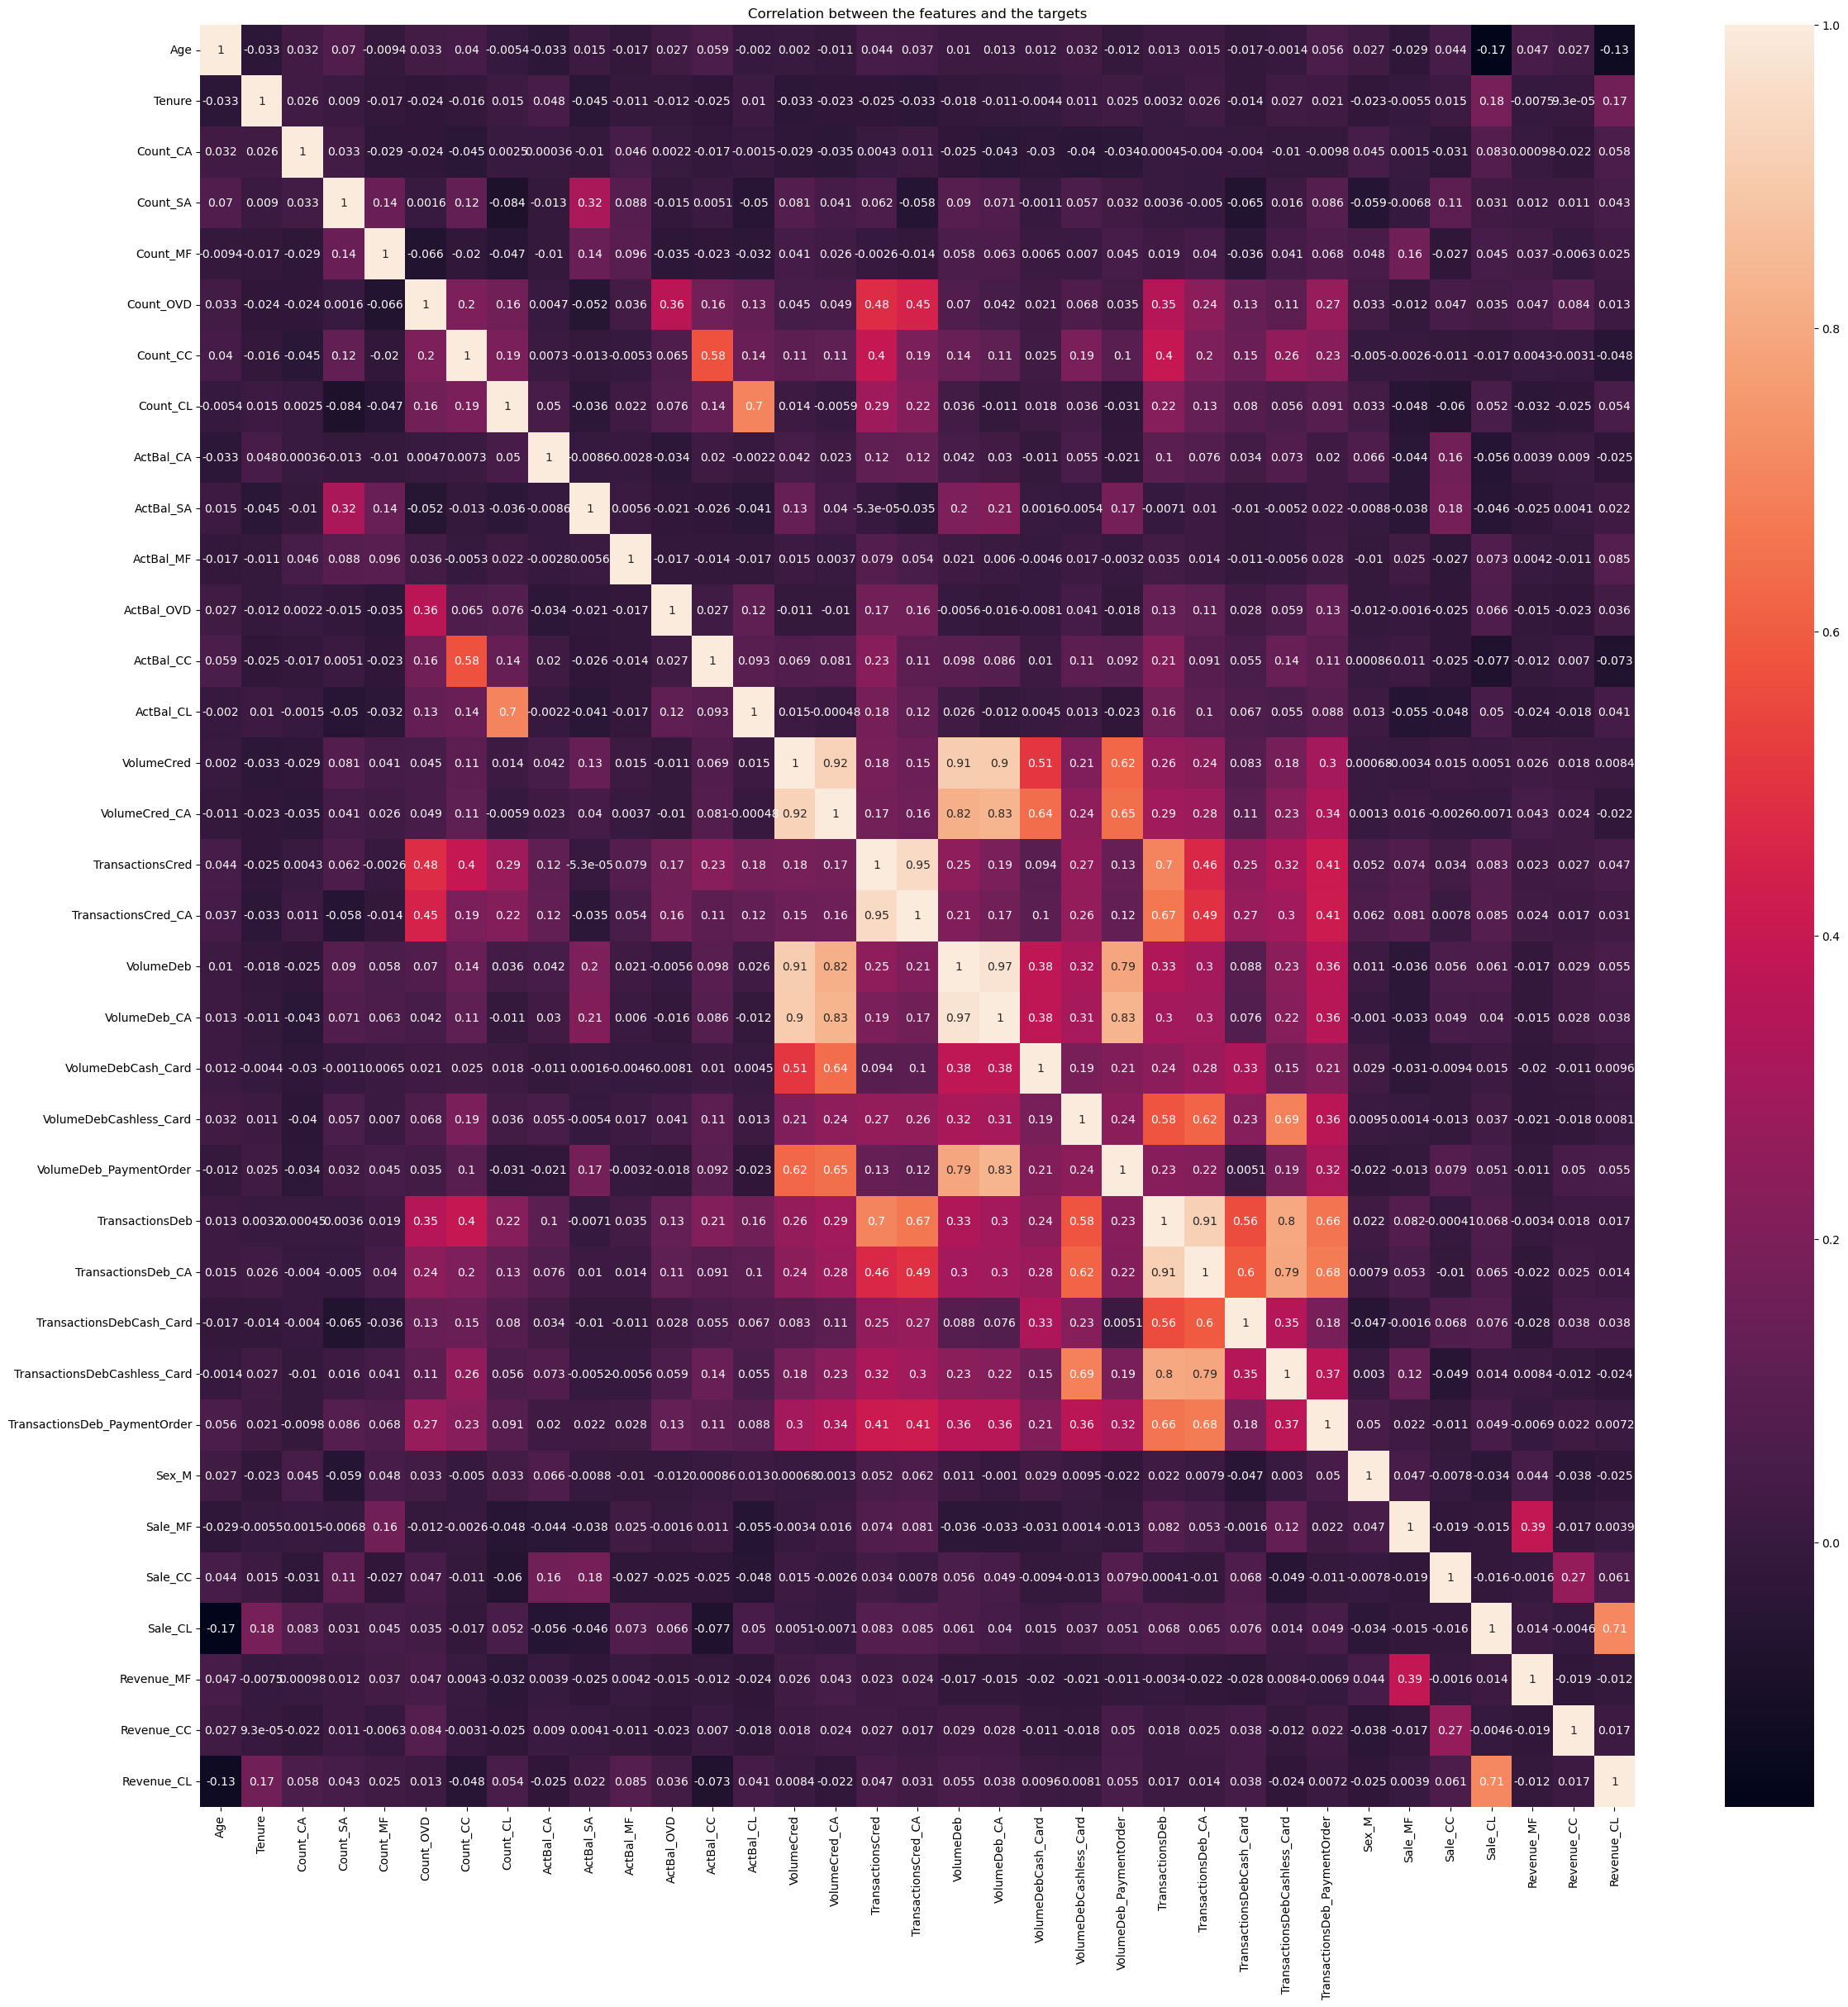

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Perform correlation analysis between the numeric features and the targets, to check if feature selection can be carried out.
df_numeric = df_modeling.drop(['Client'], axis=1).astype('float32')
corr = df_numeric.corr()
fig, ax = plt.subplots(figsize=(28, 28))
g = sns.heatmap(corr, ax=ax, annot=True)
ax.set_title("Correlation between the features and the targets")

In [11]:
# Enrich the data by creating new features

df_enriched_features = df_encoded_Soc_Products_Flow.copy()

# Create flag features for different accounts
df_enriched_features['has_Count_SA'] = np.where(df_enriched_features['Count_SA'] > 0, 1, 0)
df_enriched_features['has_Count_MF'] = np.where(df_enriched_features['Count_MF'] > 0, 1, 0)
df_enriched_features['has_Count_CL'] = np.where(df_enriched_features['Count_CL'] > 0, 1, 0)

# Create average balance features for different accounts
df_enriched_features['avgBal_SA'] = np.where(df_enriched_features['Count_SA'] == 0, 0, df_enriched_features['ActBal_SA'] / df_enriched_features['Count_SA'])
df_enriched_features['avgBal_MF'] = np.where(df_enriched_features['Count_MF'] == 0, 0, df_enriched_features['ActBal_MF'] / df_enriched_features['Count_MF'])
df_enriched_features['avgBal_CL'] = np.where(df_enriched_features['Count_CL'] == 0, 0, df_enriched_features['ActBal_CL'] / df_enriched_features['Count_CL'])

# Create flag features for different types of transactions
df_enriched_features['has_TransactionsCred'] = np.where(df_enriched_features['TransactionsCred'] > 0, 1, 0)
df_enriched_features['has_TransactionsCred_CA'] = np.where(df_enriched_features['TransactionsCred_CA'] > 0, 1, 0)
df_enriched_features['has_TransactionsCred_nonCA'] = np.where((df_enriched_features['TransactionsCred'] > 0) \
                                                  & (df_enriched_features['TransactionsCred'] > df_enriched_features['TransactionsCred_CA']), 1, 0)
df_enriched_features['has_TransactionsDeb'] = np.where(df_enriched_features['TransactionsDeb'] > 0, 1, 0)
df_enriched_features['has_TransactionsDeb_nonCA'] = np.where((df_enriched_features['TransactionsDeb'] > 0) \
                                                  & (df_enriched_features['TransactionsDeb'] > df_enriched_features['TransactionsDeb_CA']), 1, 0)
df_enriched_features['has_TransactionsDebCash'] = np.where(df_enriched_features['TransactionsDebCash_Card'] > 0, 1, 0)
df_enriched_features['has_TransactionsDebCashless'] = np.where(df_enriched_features['TransactionsDebCashless_Card'] > 0, 1, 0)
df_enriched_features['has_PaymentOrder'] = np.where(df_enriched_features['TransactionsDeb_PaymentOrder'] > 0, 1, 0)

# Create average transaction turnover features
df_enriched_features['avg_VolumeCred'] = np.where(df_enriched_features['TransactionsCred'] == 0, 0, df_enriched_features['VolumeCred'] / df_enriched_features['TransactionsCred'])
df_enriched_features['avg_VolumeCred_CA'] = np.where(df_enriched_features['TransactionsCred_CA'] == 0, 0, df_enriched_features['VolumeCred_CA'] / df_enriched_features['TransactionsCred_CA'])
df_enriched_features['avg_VolumeDeb'] = np.where(df_enriched_features['TransactionsDeb'] == 0, 0, df_enriched_features['VolumeDeb'] / df_enriched_features['TransactionsDeb'])
df_enriched_features['avg_VolumeDeb_CA'] = np.where(df_enriched_features['TransactionsDeb_CA'] == 0, 0, df_enriched_features['VolumeDeb_CA'] / df_enriched_features['TransactionsDeb_CA'])
df_enriched_features['avg_VolumeDebCash'] = np.where(df_enriched_features['TransactionsDebCash_Card'] == 0, 0, df_enriched_features['VolumeDebCash_Card'] / df_enriched_features['TransactionsDebCash_Card'])
df_enriched_features['avg_VolumeDebCashless'] = np.where(df_enriched_features['TransactionsDebCashless_Card'] == 0, 0, df_enriched_features['VolumeDebCashless_Card'] / df_enriched_features['TransactionsDebCashless_Card'])
df_enriched_features['avg_VolumeDeb_PaymentOrder'] = np.where(df_enriched_features['TransactionsDeb_PaymentOrder'] == 0, 0, df_enriched_features['VolumeDeb_PaymentOrder'] / df_enriched_features['TransactionsDeb_PaymentOrder'])

# Create difference features
df_enriched_features['VolumeCred_nonCA'] = df_enriched_features['VolumeCred'] - df_enriched_features['VolumeCred_CA']
df_enriched_features['VolumeDeb_nonCA'] = df_enriched_features['VolumeDeb'] - df_enriched_features['VolumeDeb_CA']

df_modeling_enriched = pd.merge(left=df_enriched_features, right=df_Sales_Revenues, left_on='Client', right_on='Client')

Text(0.5, 1.0, 'Correlation between the created features and the targets')

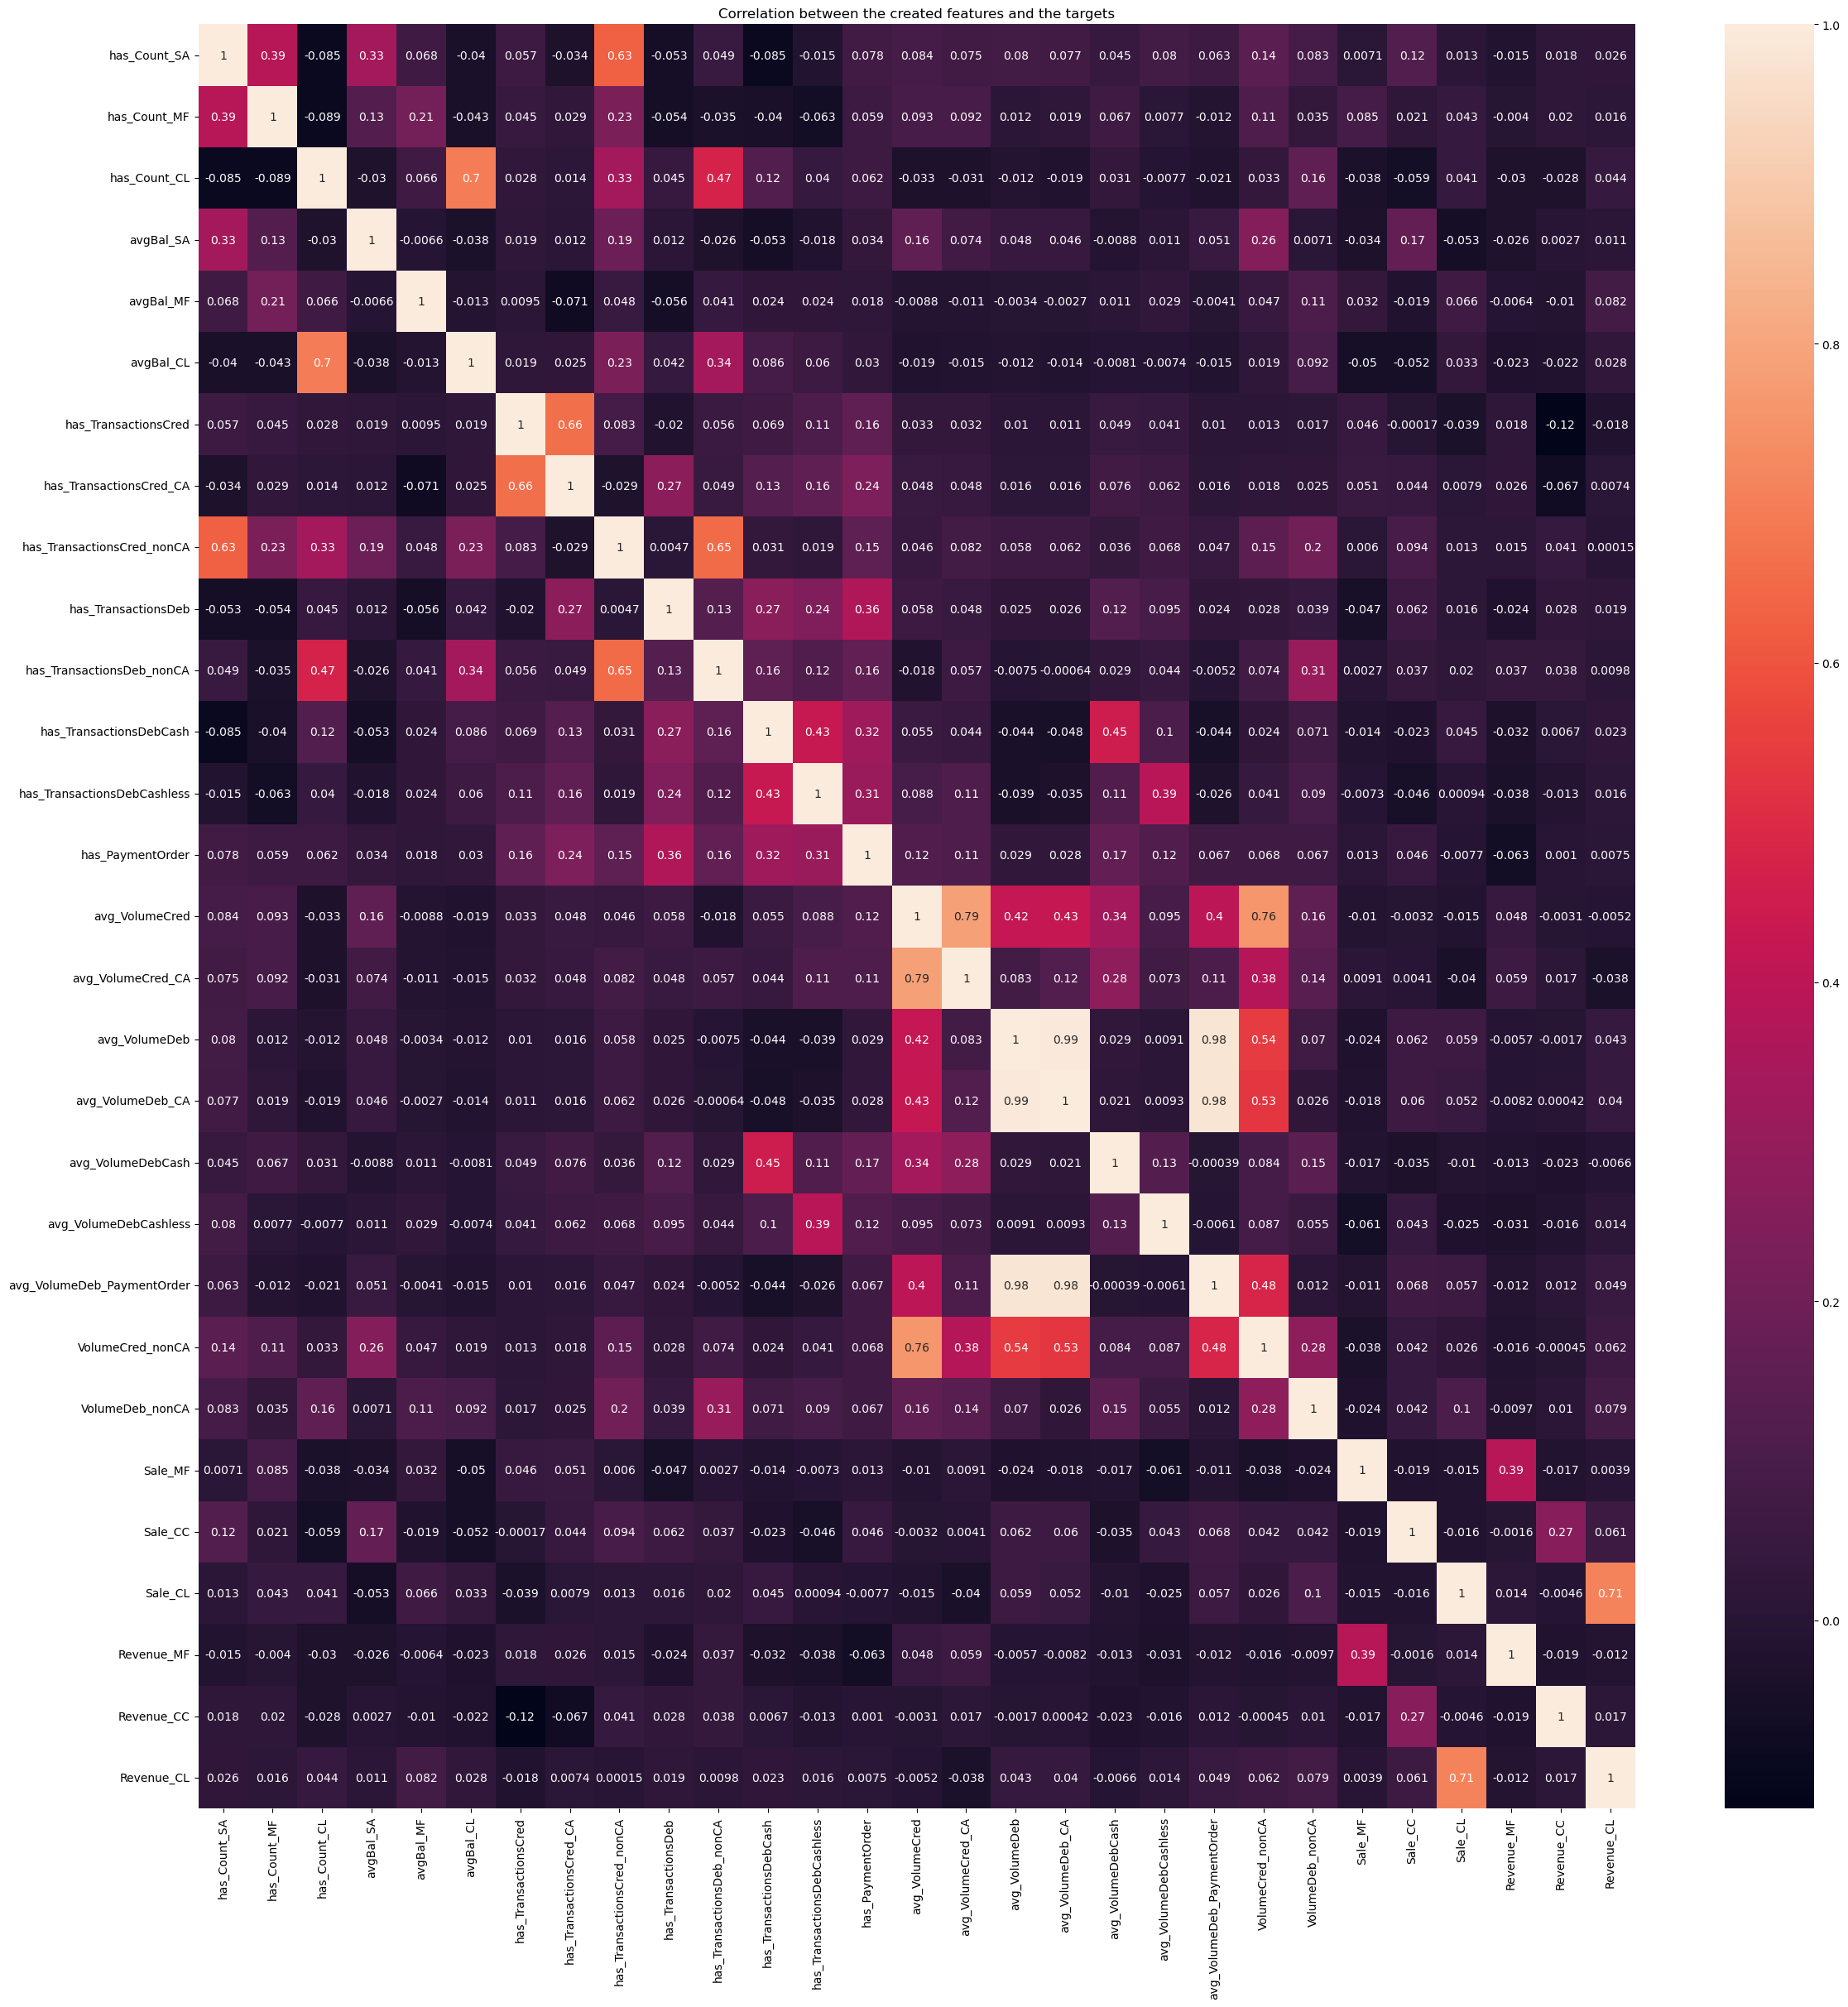

In [12]:
# Investigate the correlation between the created features and the targets

df_new_features = df_modeling_enriched.drop(['Client',
                             'Sex_M',
                             'Age',
                             'Tenure',
                             'Count_CA',
                             'Count_SA',
                             'Count_MF',
                             'Count_OVD',
                             'Count_CC',
                             'Count_CL',
                             'ActBal_CA',
                             'ActBal_SA',
                             'ActBal_MF',
                             'ActBal_OVD',
                             'ActBal_CC',
                             'ActBal_CL',
                             'VolumeCred',
                             'VolumeCred_CA',
                             'TransactionsCred',
                             'TransactionsCred_CA',
                             'VolumeDeb',
                             'VolumeDeb_CA',
                             'VolumeDebCash_Card',
                             'VolumeDebCashless_Card',
                             'VolumeDeb_PaymentOrder',
                             'TransactionsDeb',
                             'TransactionsDeb_CA',
                             'TransactionsDebCash_Card',
                             'TransactionsDebCashless_Card',
                             'TransactionsDeb_PaymentOrder',], axis=1).astype('float32')
                             
corr = df_new_features.corr()
fig, ax = plt.subplots(figsize=(28, 28))
g = sns.heatmap(corr, ax=ax, annot=True)
ax.set_title("Correlation between the created features and the targets")
                             

#### <span style="color:orange">**Comments**</span>

* The correlation between the original/created features and the targets are usually low. No correlation coefficients are much higher or lowed than others.
* No numerical features are fully correlated with another.
* Therefore, based on the correlation analysis, no original/created features will be eliminated for modeling.

### Handling Skewness in Feature Value Distribution

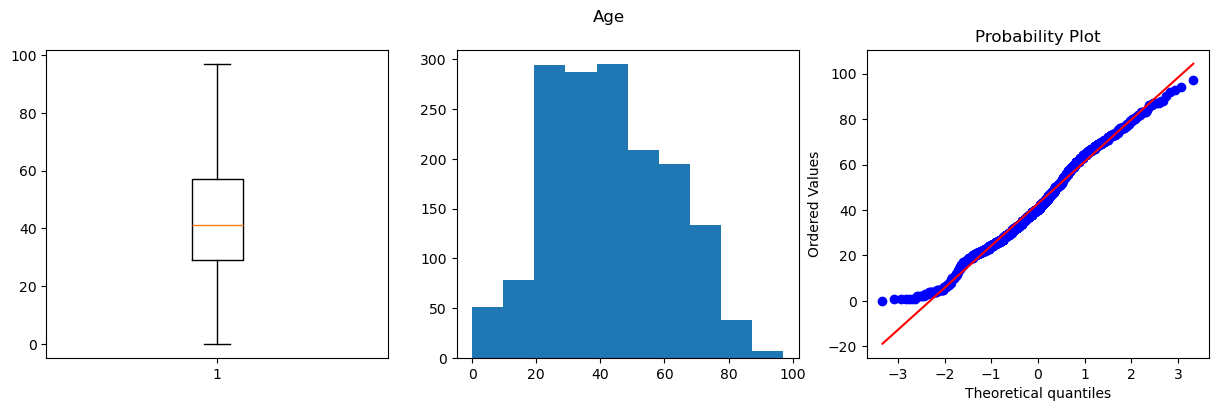

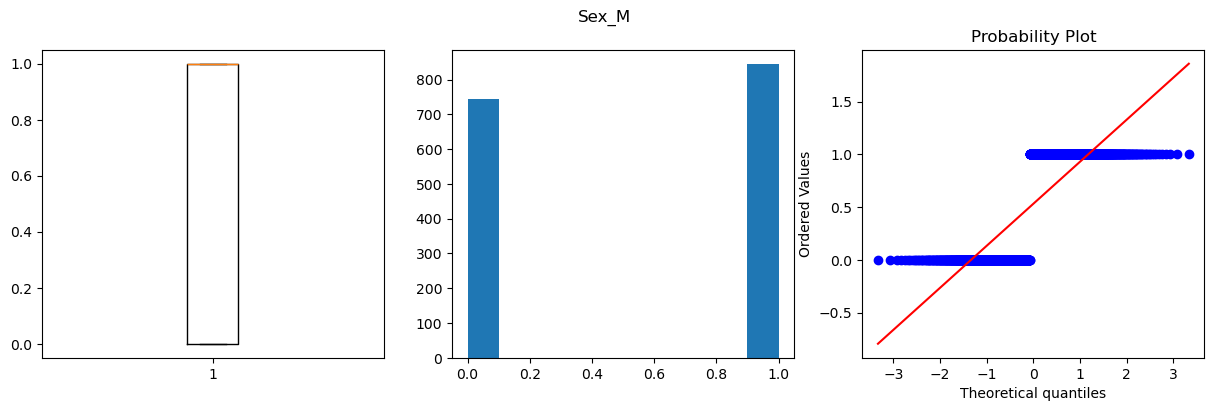

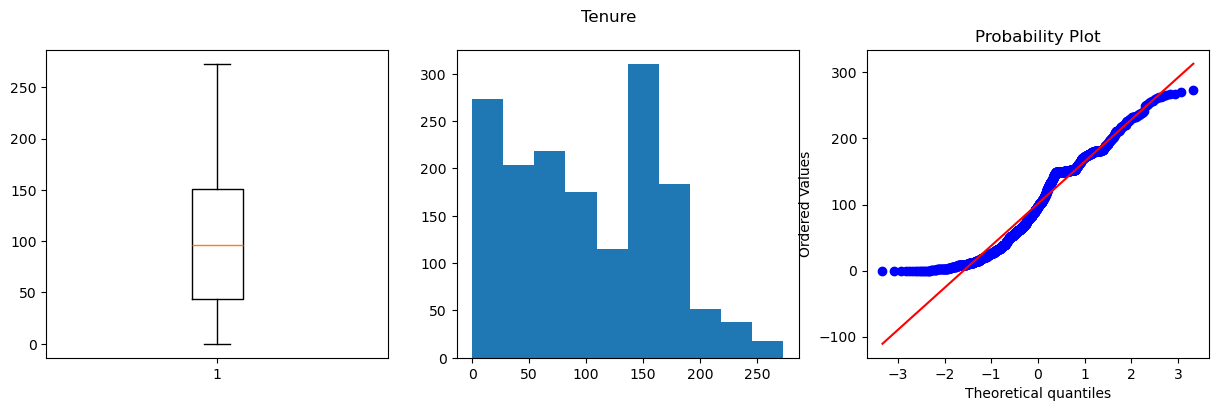

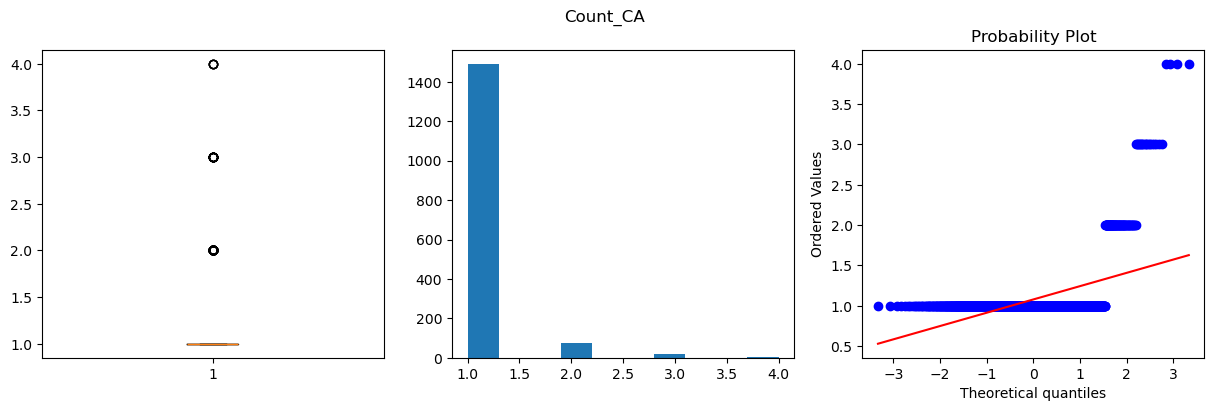

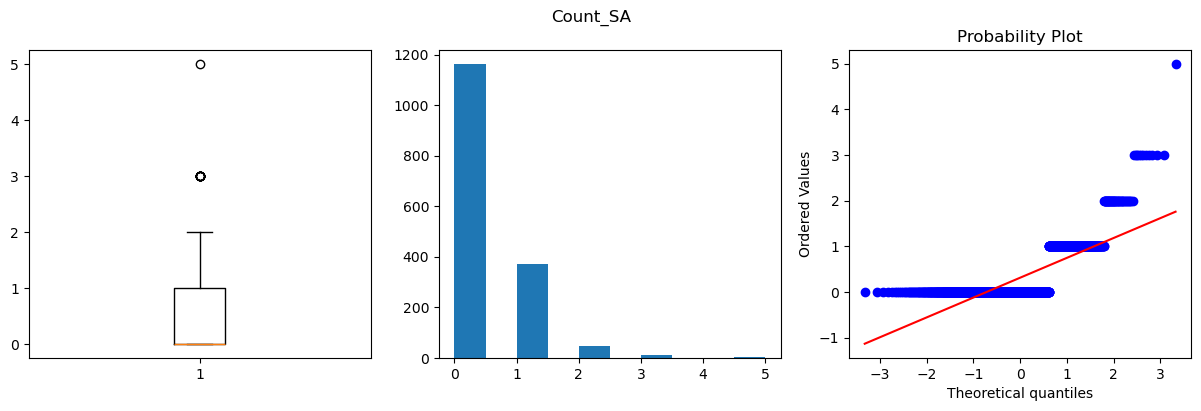

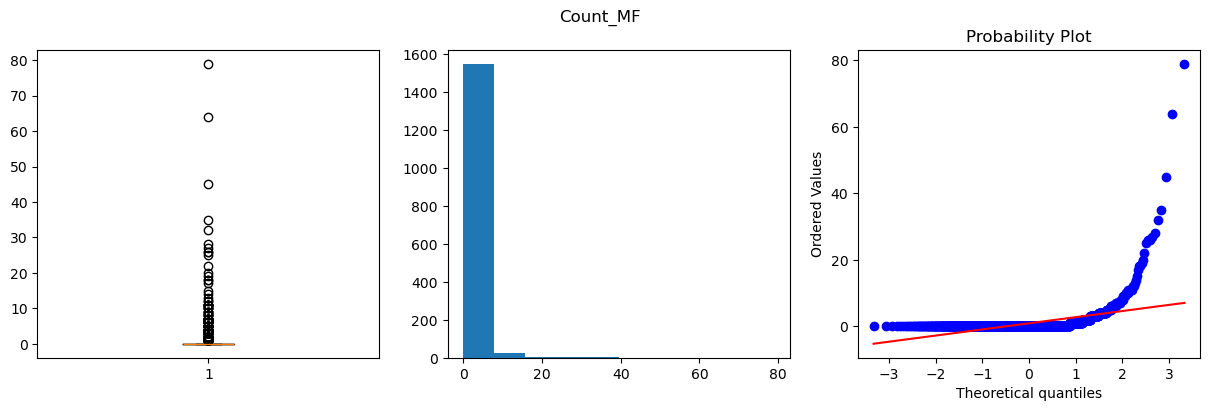

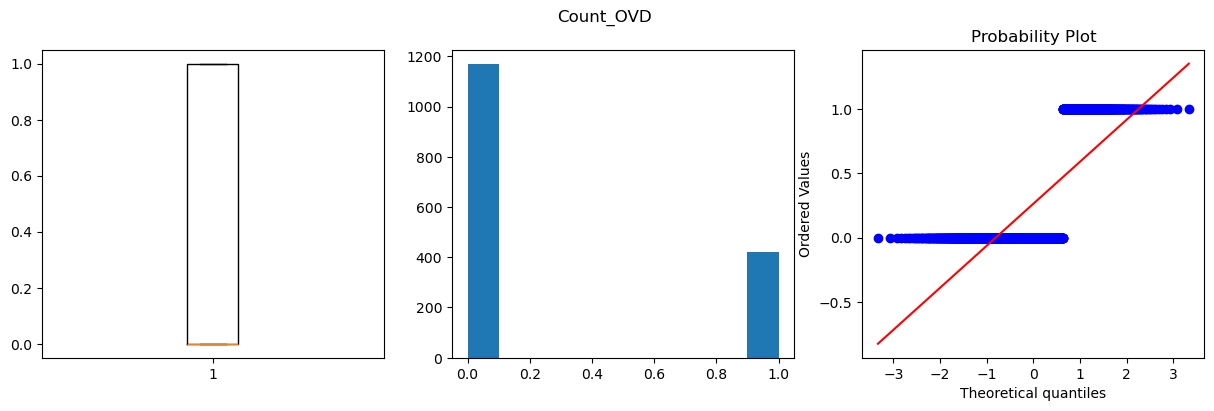

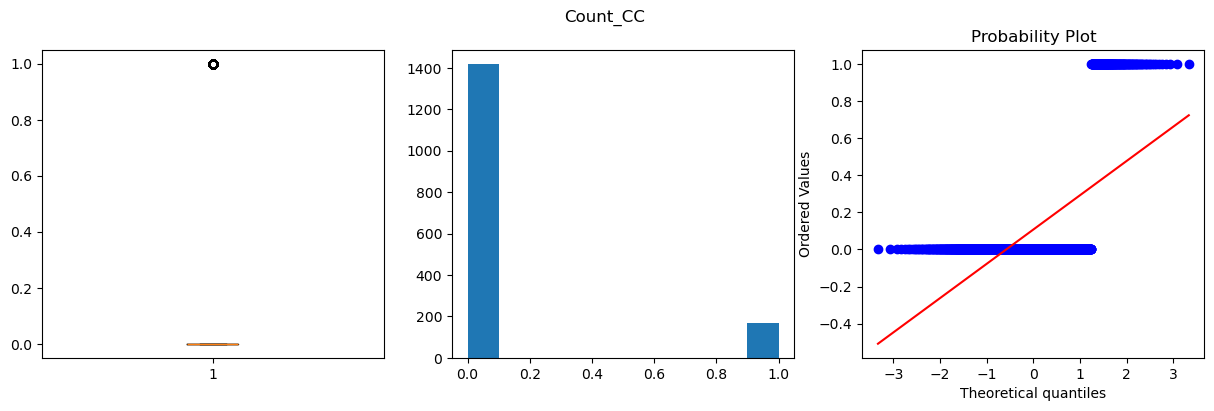

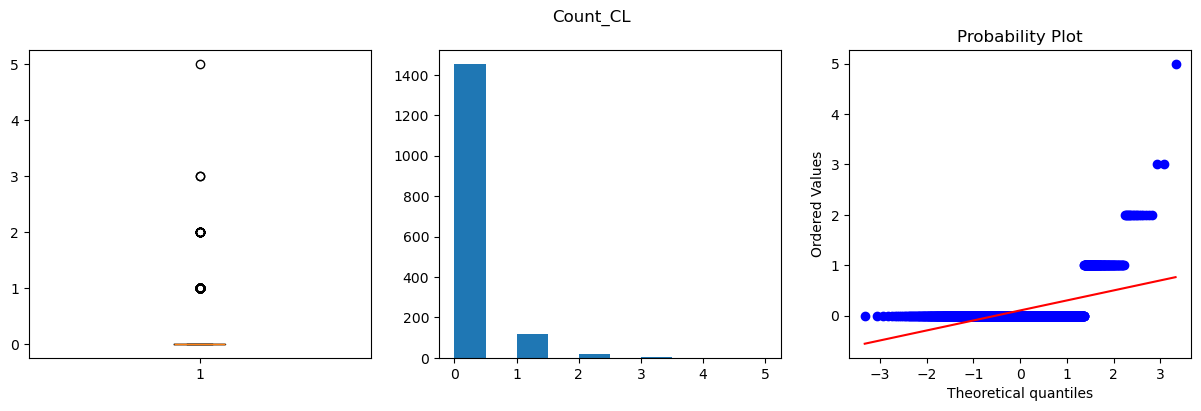

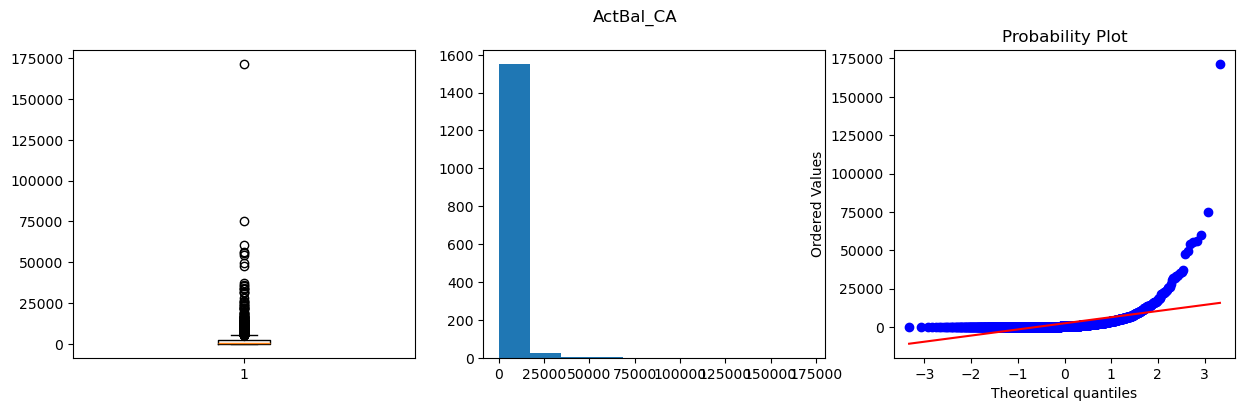

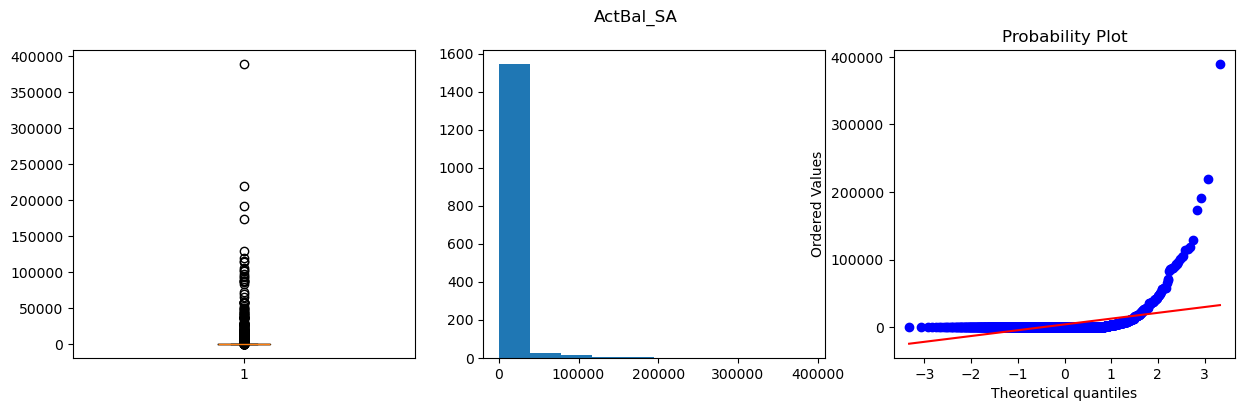

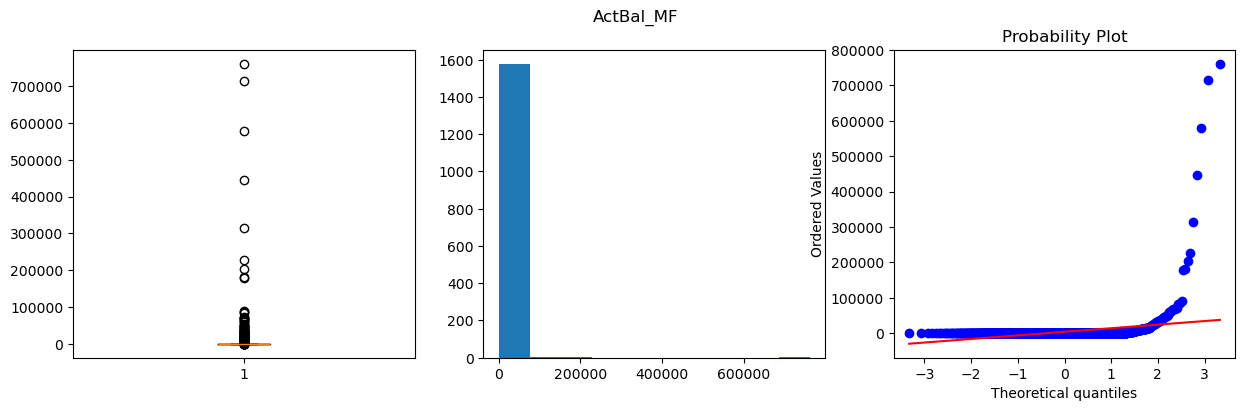

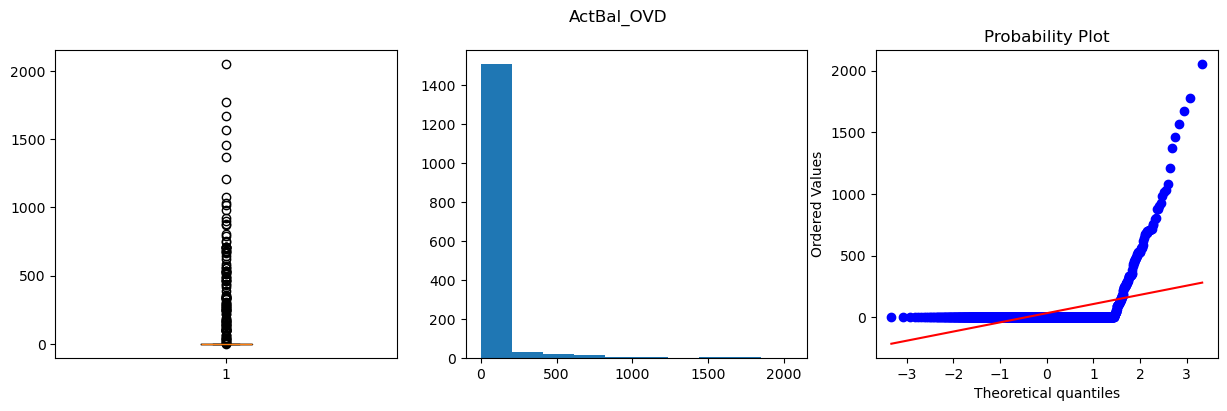

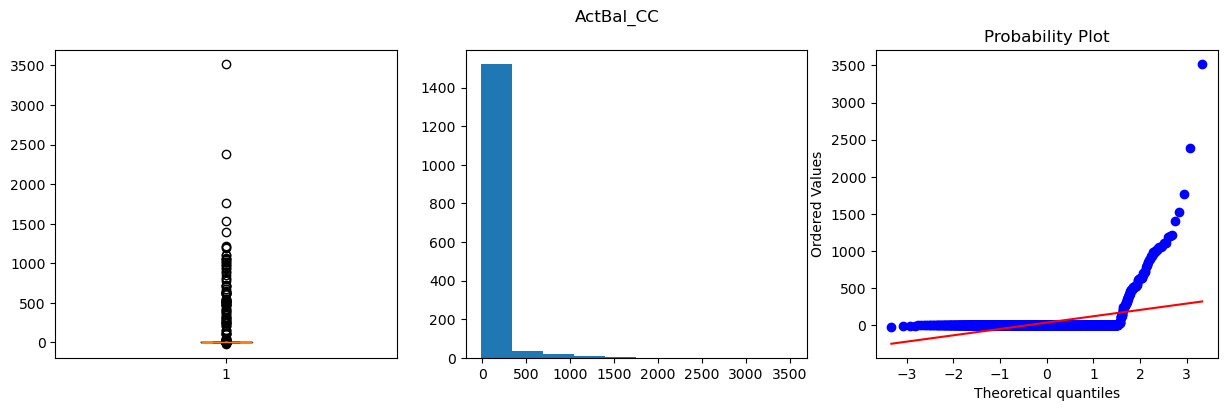

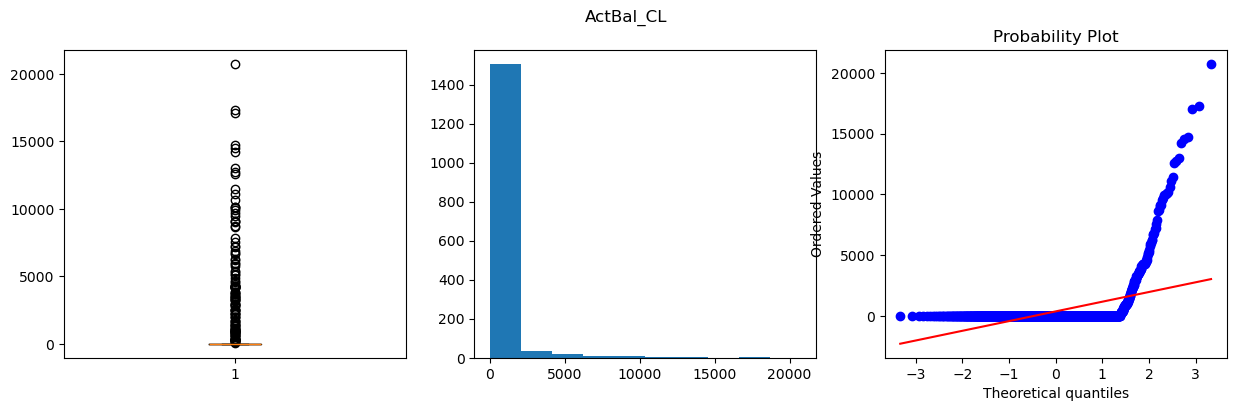

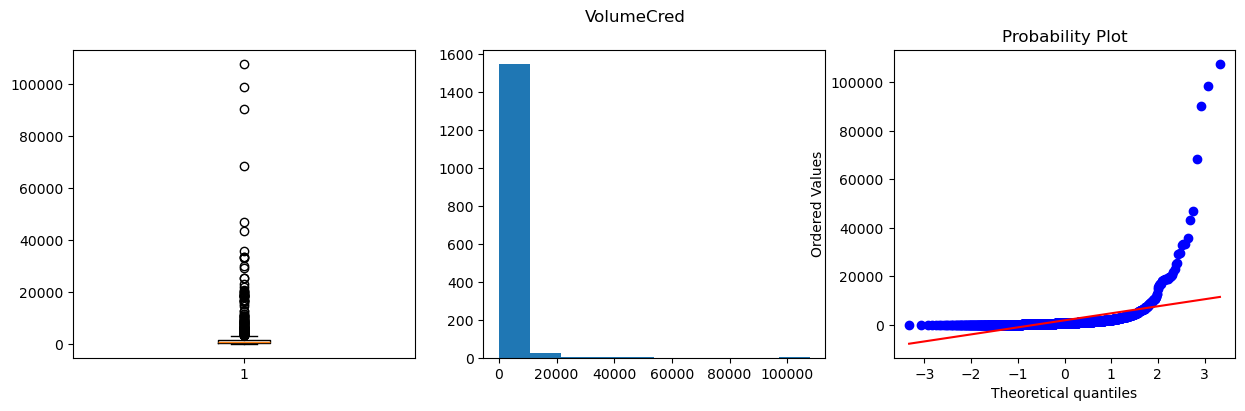

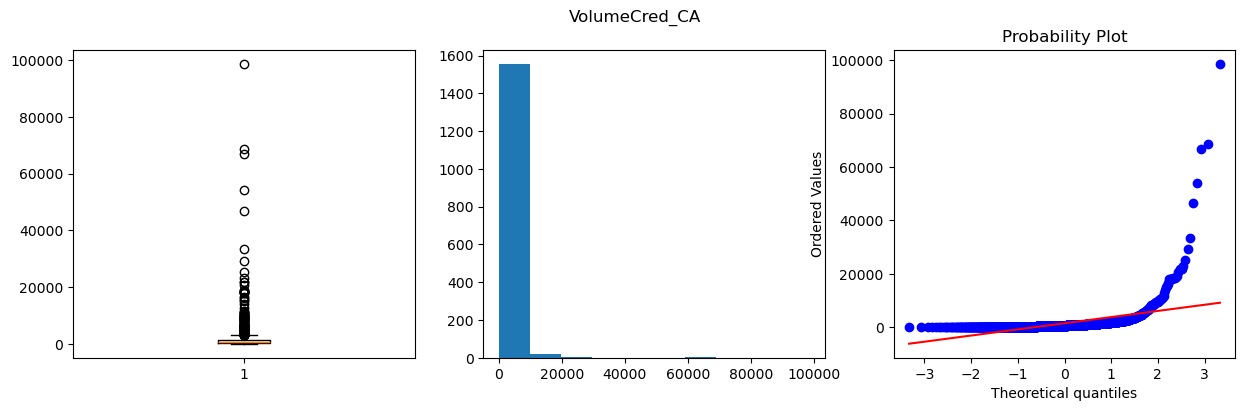

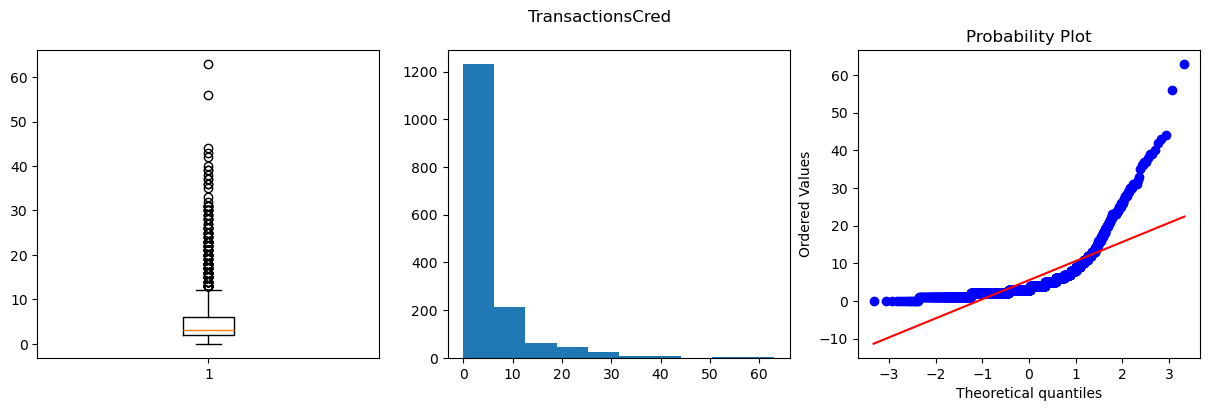

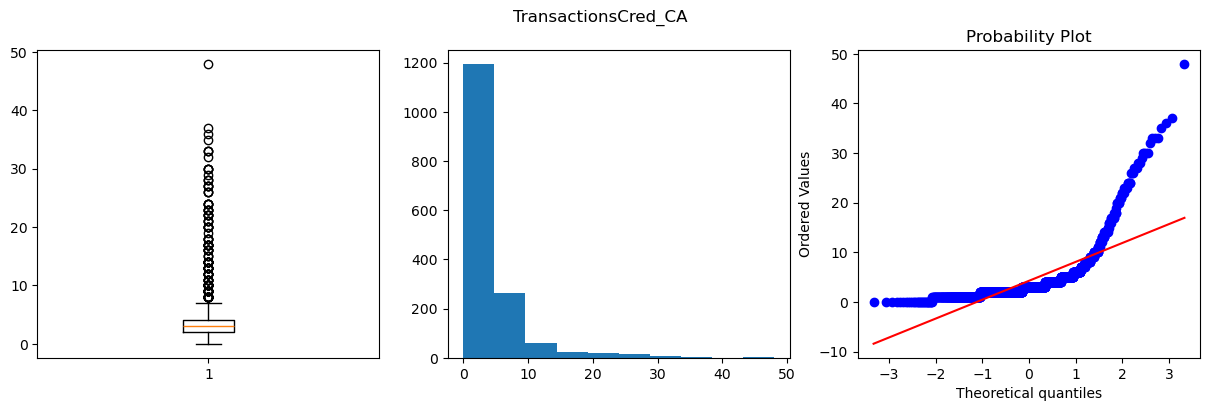

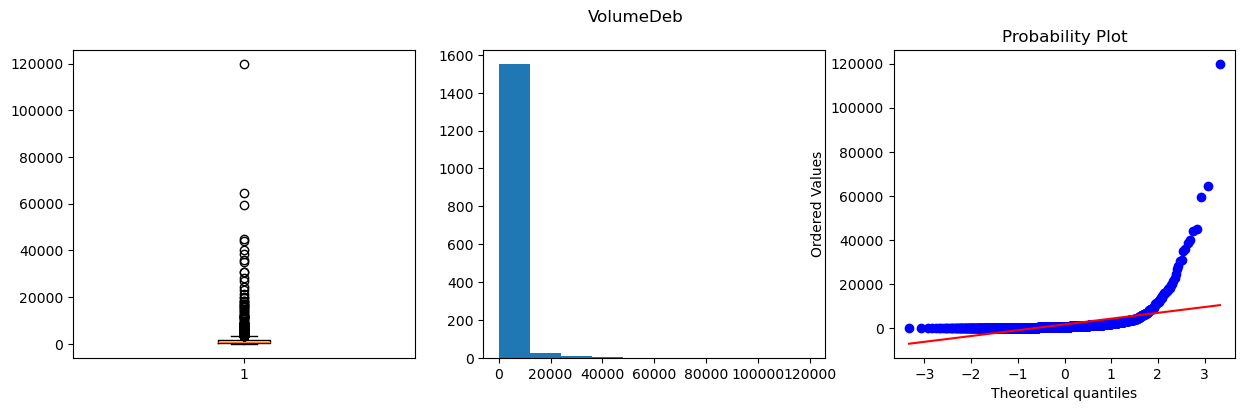

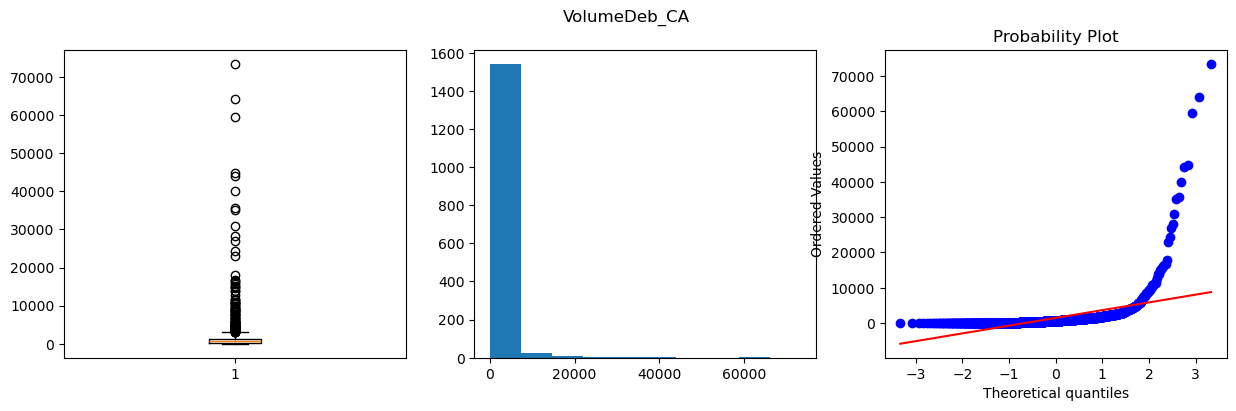

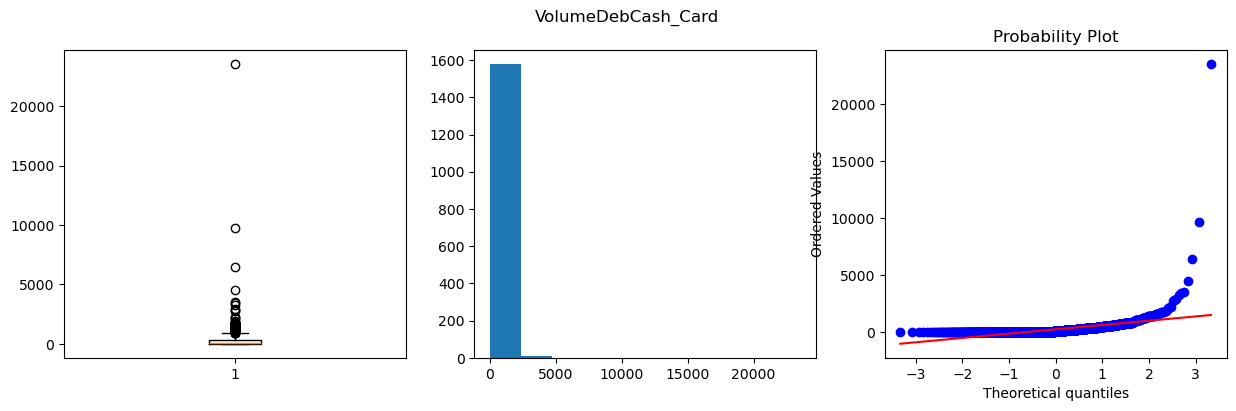

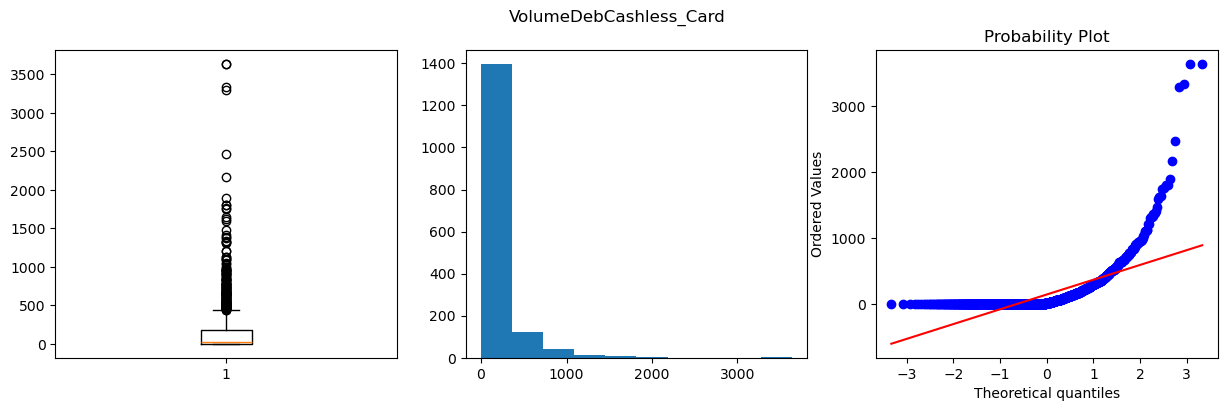

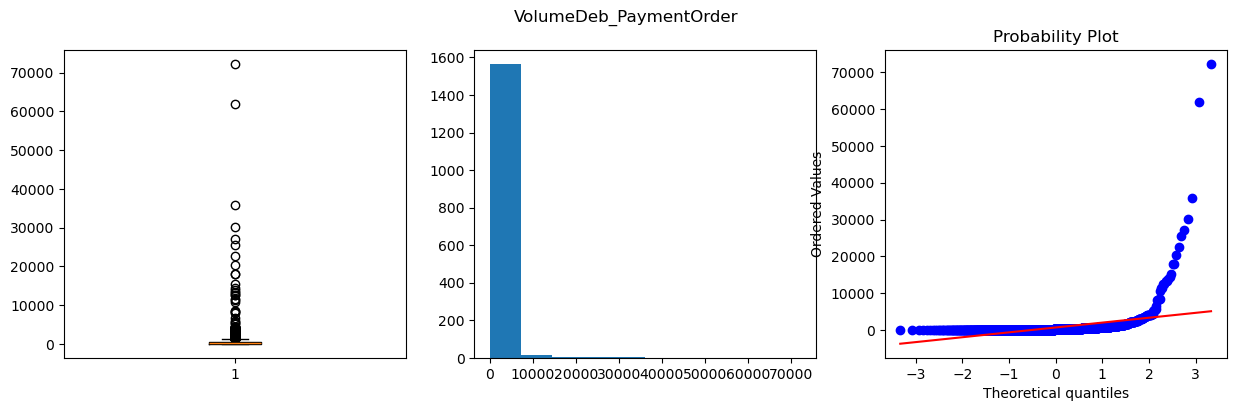

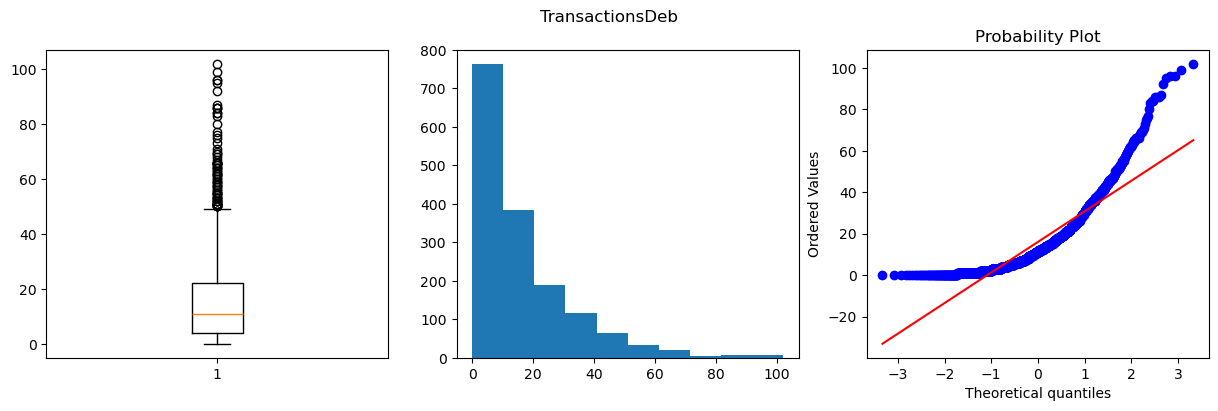

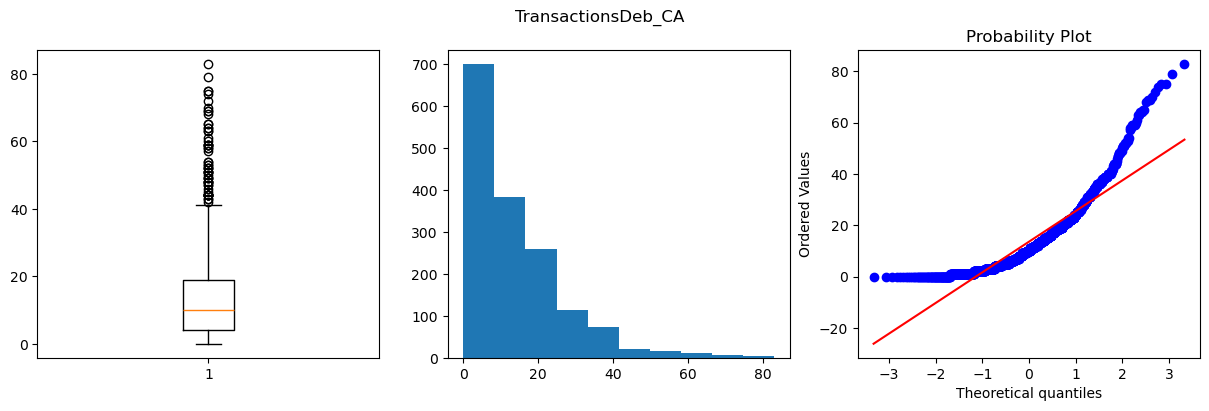

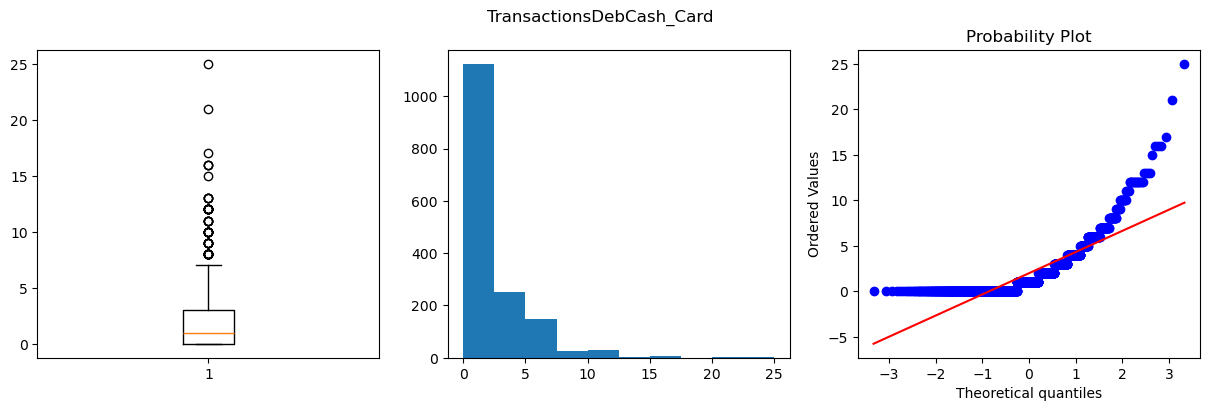

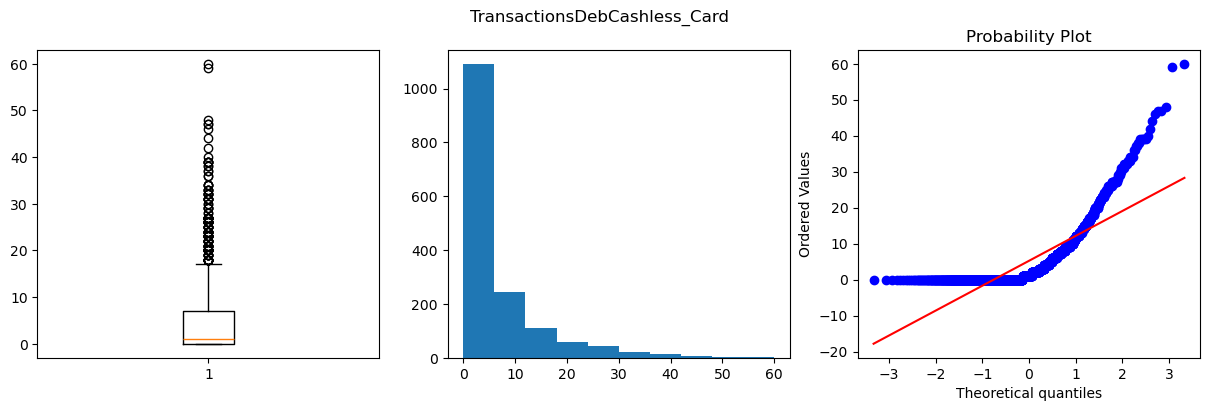

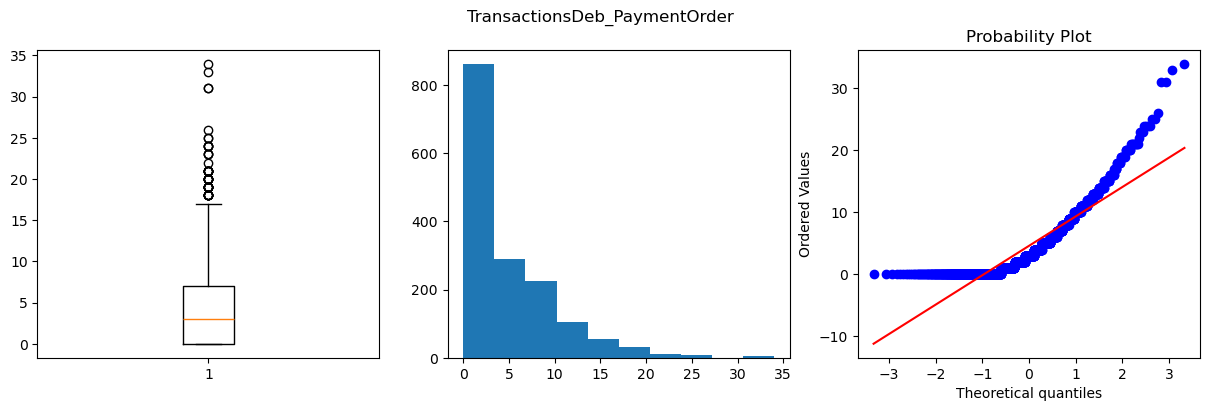

In [13]:
import scipy.stats as stats

cols = [ 'Age',
         'Sex_M',
         'Tenure',
         'Count_CA',
         'Count_SA',
         'Count_MF',
         'Count_OVD',
         'Count_CC',
         'Count_CL',
         'ActBal_CA',
         'ActBal_SA',
         'ActBal_MF',
         'ActBal_OVD',
         'ActBal_CC',
         'ActBal_CL',
         'VolumeCred',
         'VolumeCred_CA',
         'TransactionsCred',
         'TransactionsCred_CA',
         'VolumeDeb',
         'VolumeDeb_CA',
         'VolumeDebCash_Card',
         'VolumeDebCashless_Card',
         'VolumeDeb_PaymentOrder',
         'TransactionsDeb',
         'TransactionsDeb_CA',
         'TransactionsDebCash_Card',
         'TransactionsDebCashless_Card',
         'TransactionsDeb_PaymentOrder']

for col in cols: 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    fig.suptitle(col)
    axes[0].boxplot(df_encoded_Soc_Products_Flow[col])
    axes[1].hist(df_encoded_Soc_Products_Flow[col])
    stats.probplot(df_encoded_Soc_Products_Flow[col], dist='norm', plot=axes[2])
    plt.show()

#### <span style="color:orange">**Comments**</span>

The analysis shows that:
* The distribution of 'Age', 'Sex_M' and 'Tenure' are almost not skewed. 
* The distribution of the count features 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', and 'Count_CL' are skewed, but they are discrete features and their value ranges are quite small. 
* The distribution of the count feature 'Count_MF' is skewed and its value range is big ([0, 79]). 
* The distribution of balance features and volume features, as well as the distribution of transaction count features are all left skewed. 
* The min value of 'ActBal_CC' is negative, while for other features the min values are 0.

Data transformation is going to be used to deal with the skewness of feature value distribution, to make the distribution of each numerical feature close to normal distribution form. Based on the analysis, we'd apply data transformation on the following features:
* 'Count_MF',
* all the balance features
* all the transaction count features
* all the transaction volume features

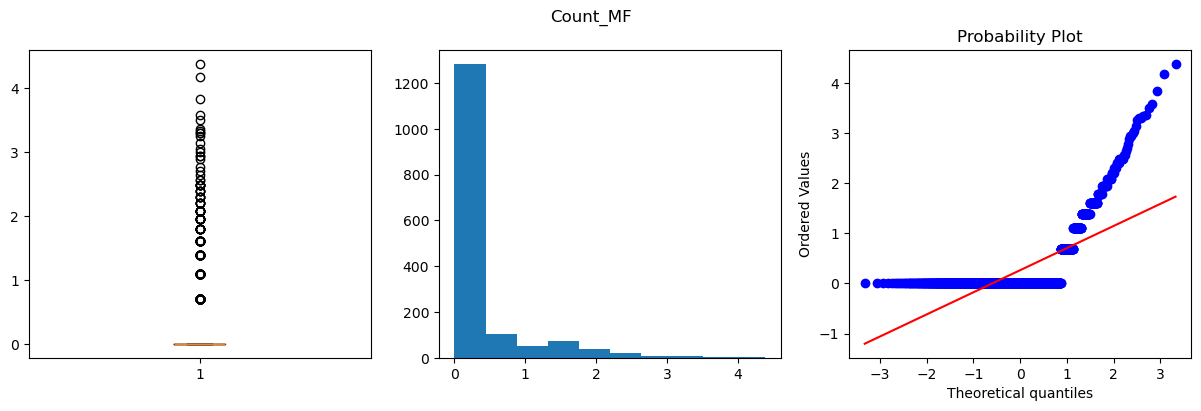

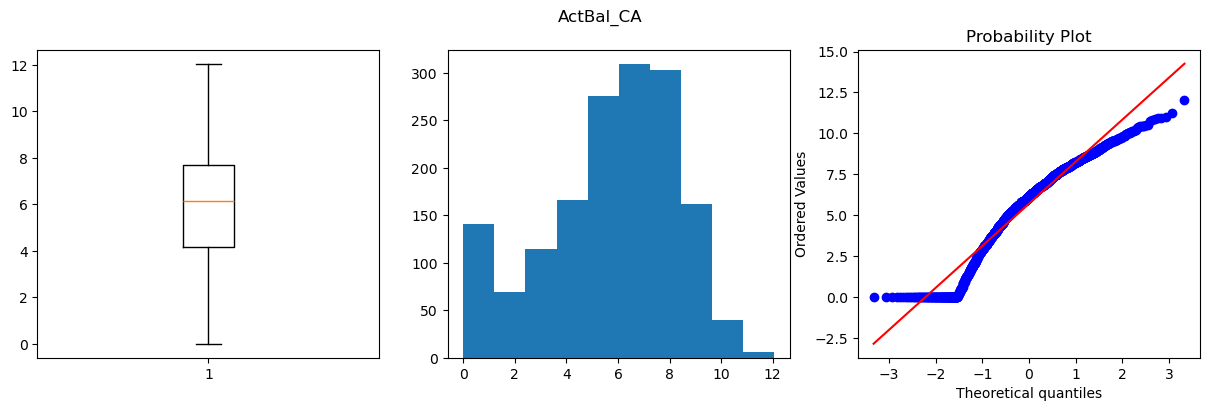

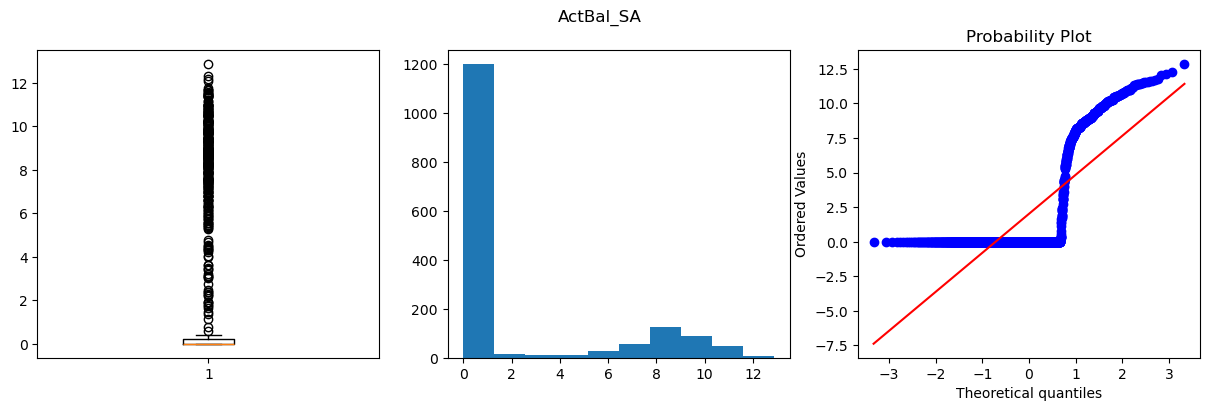

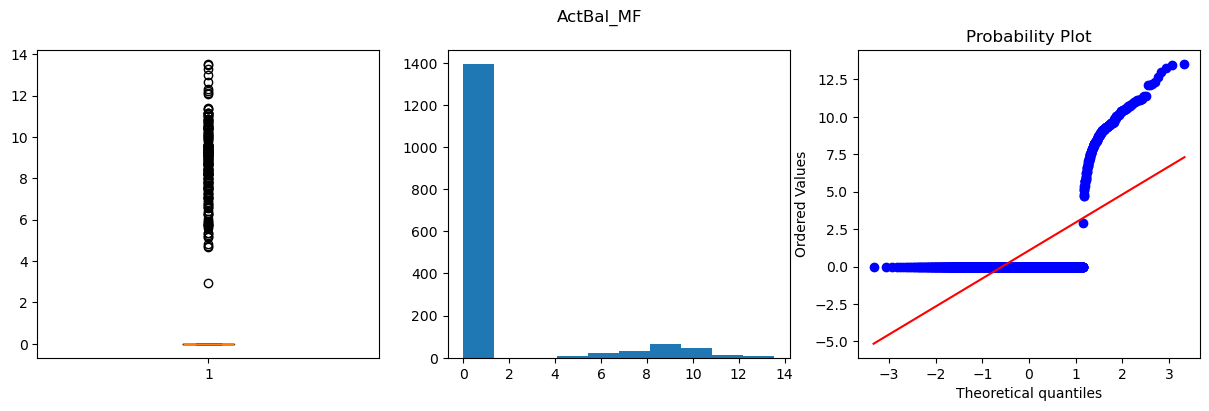

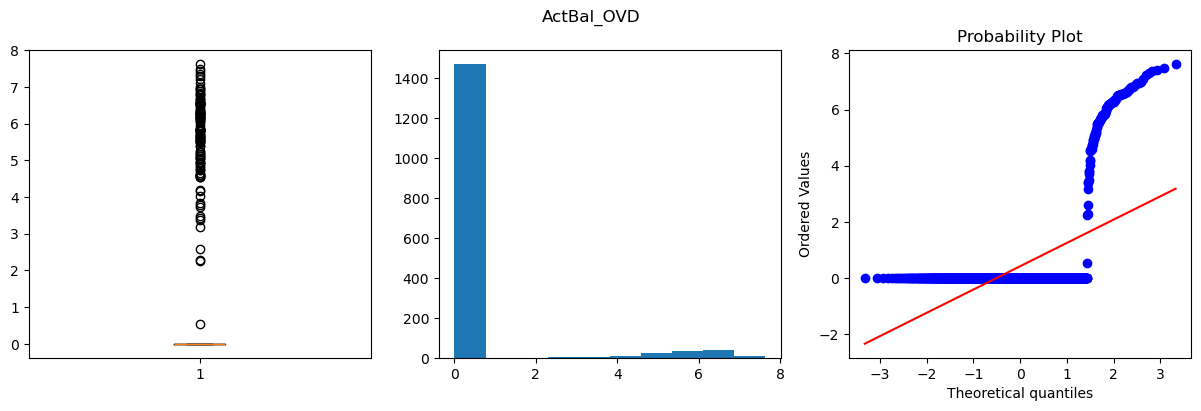

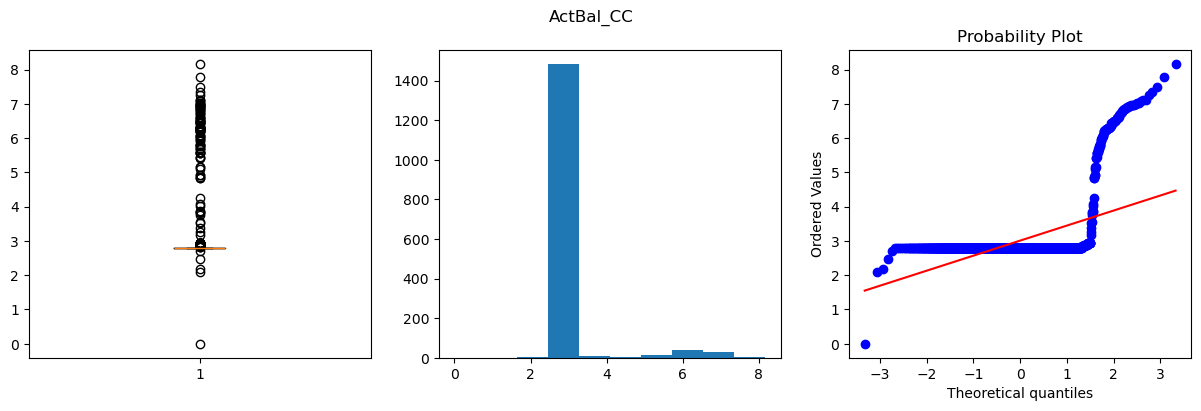

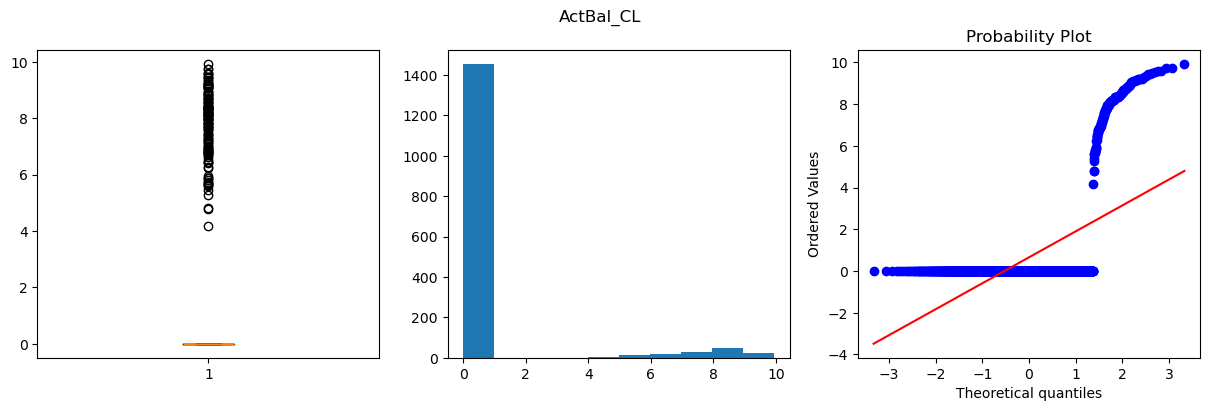

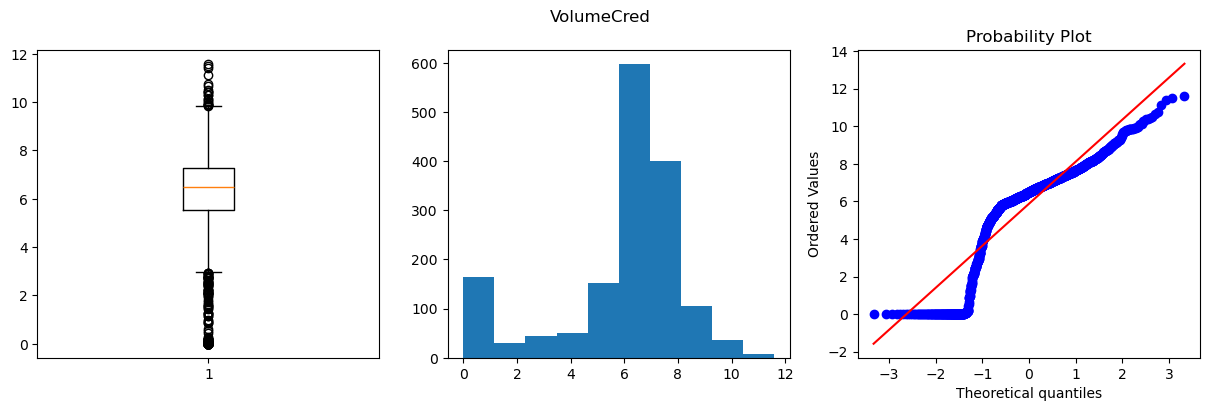

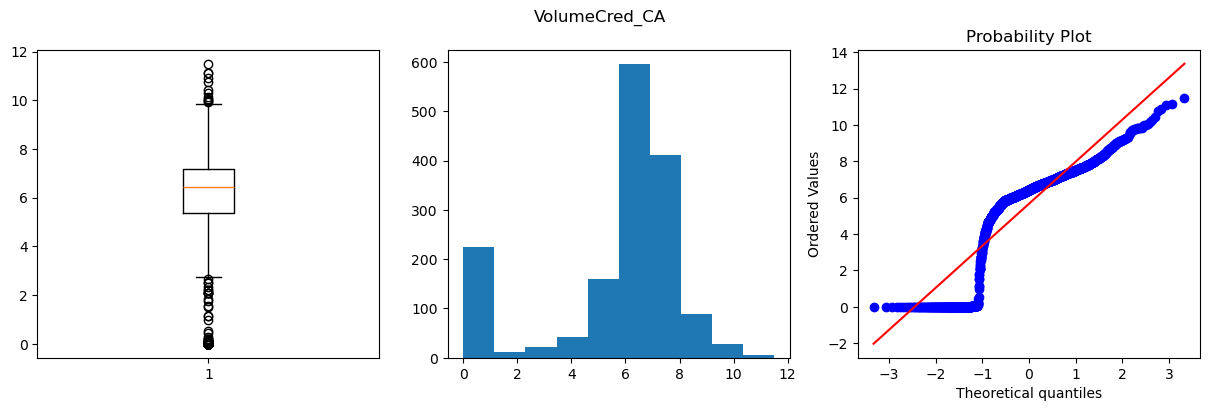

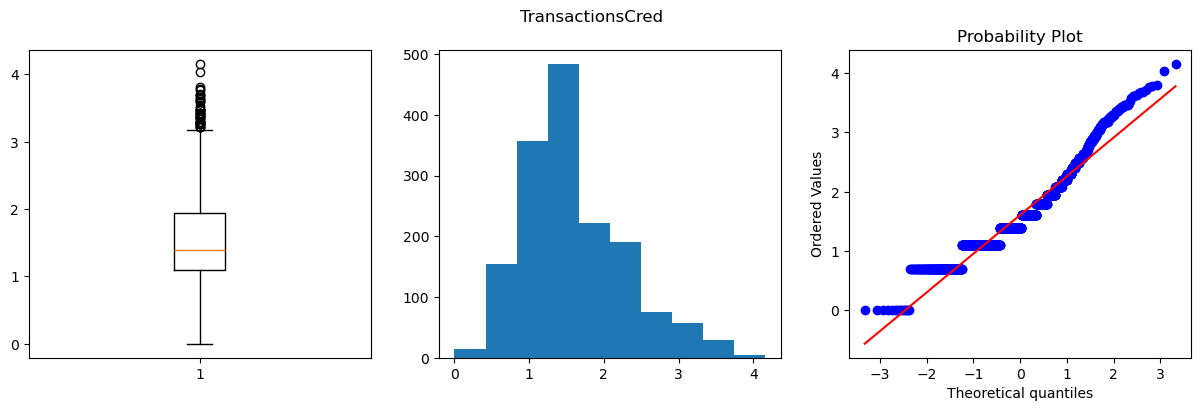

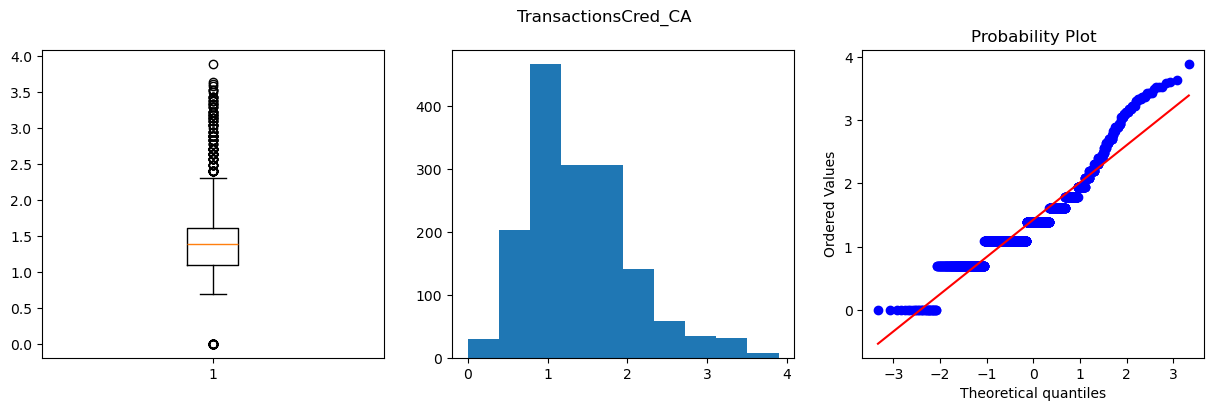

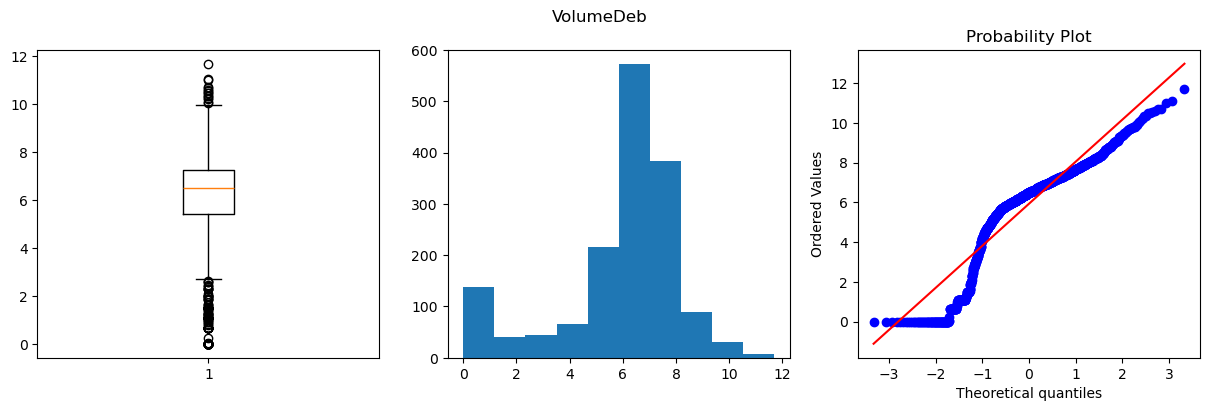

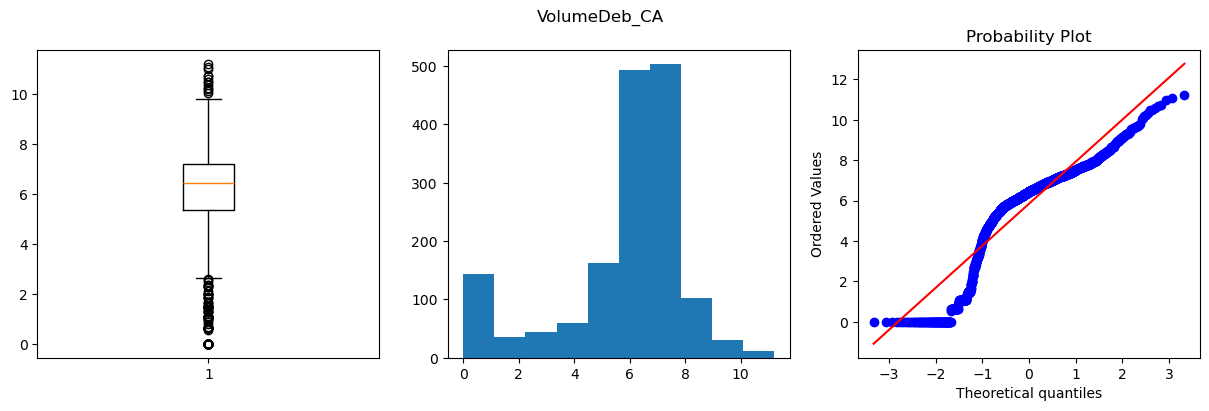

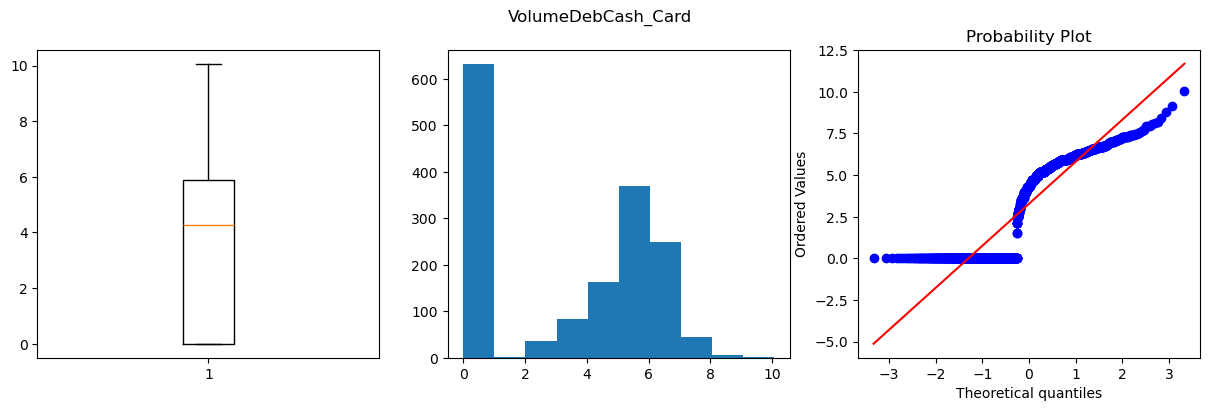

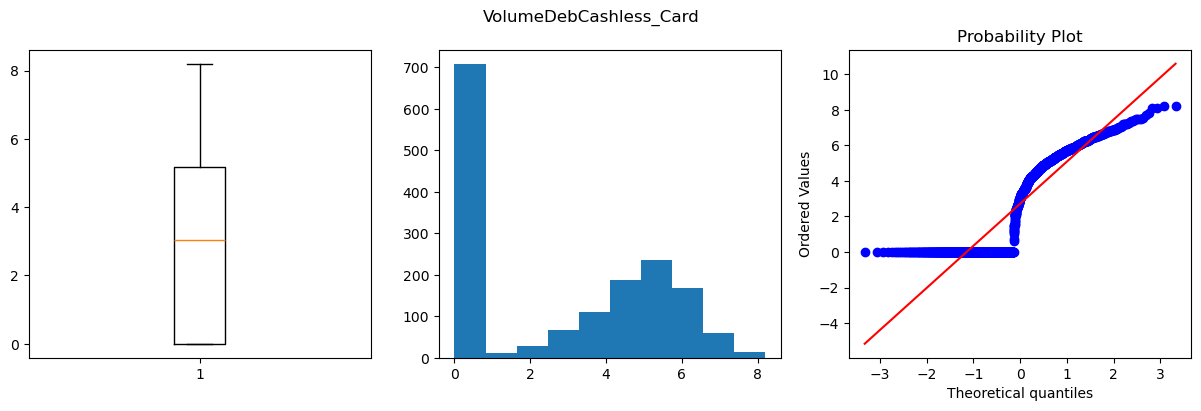

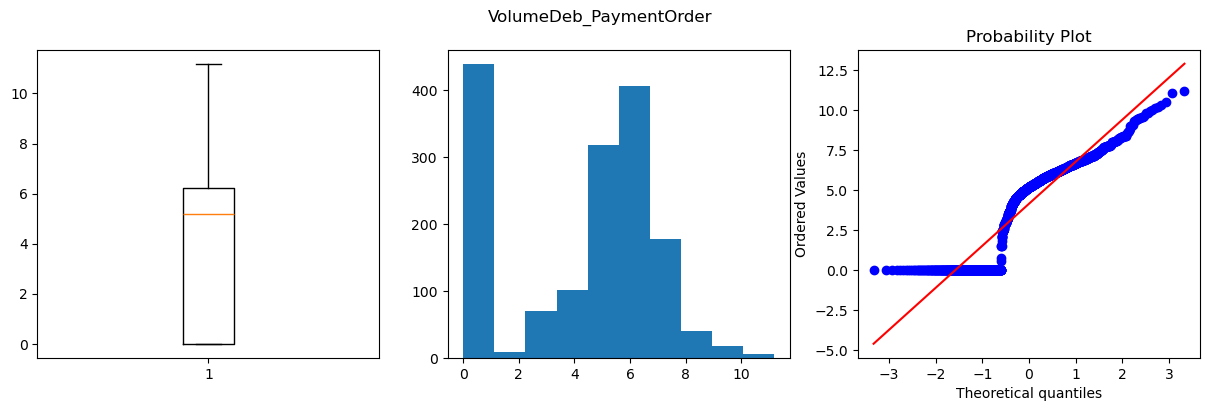

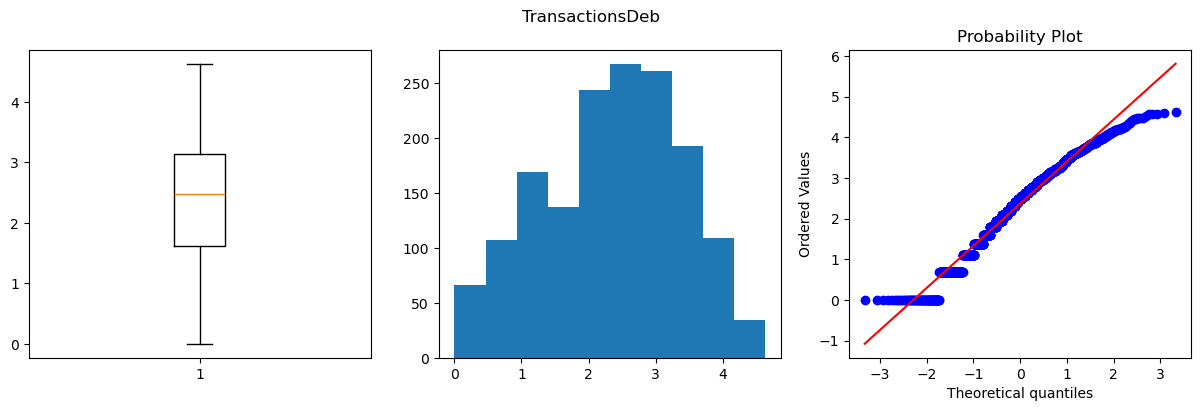

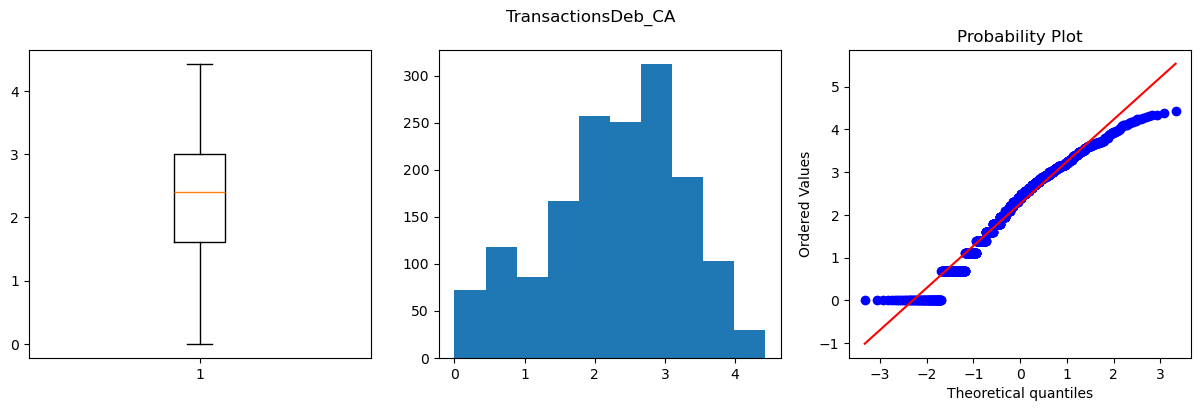

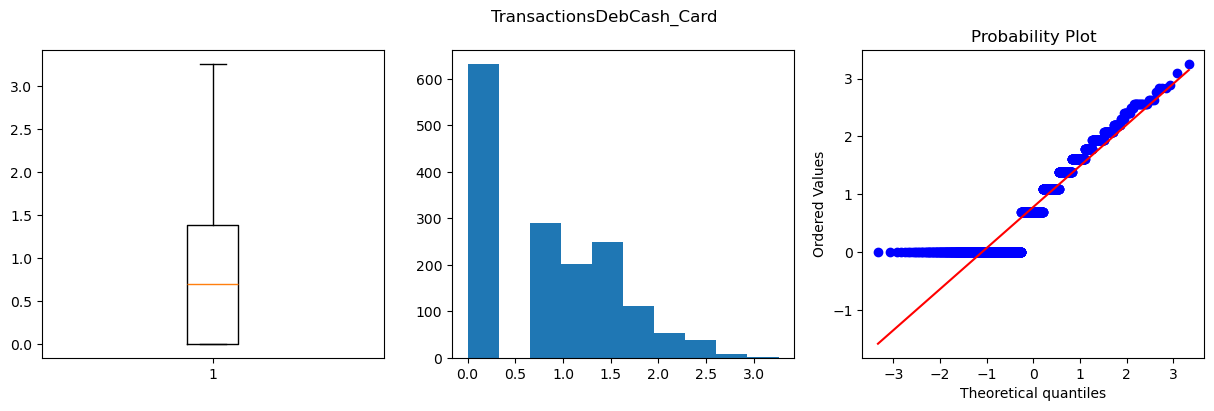

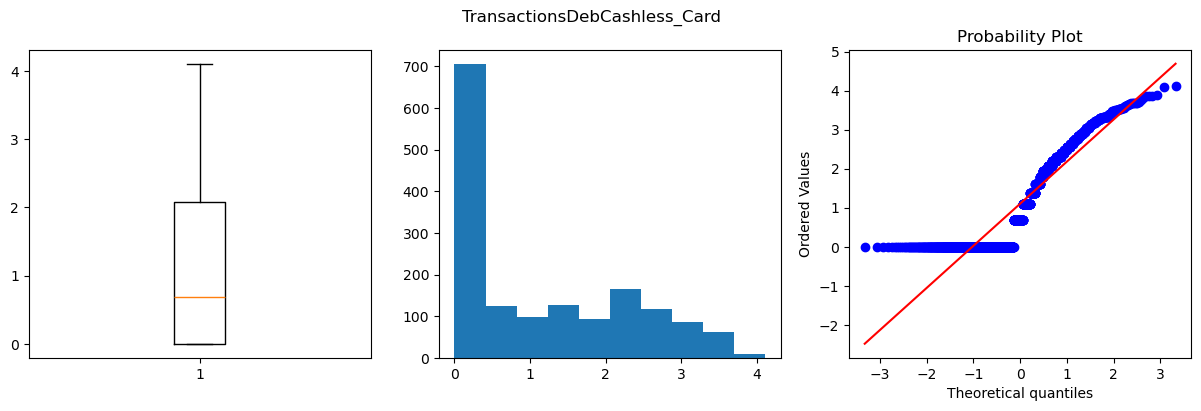

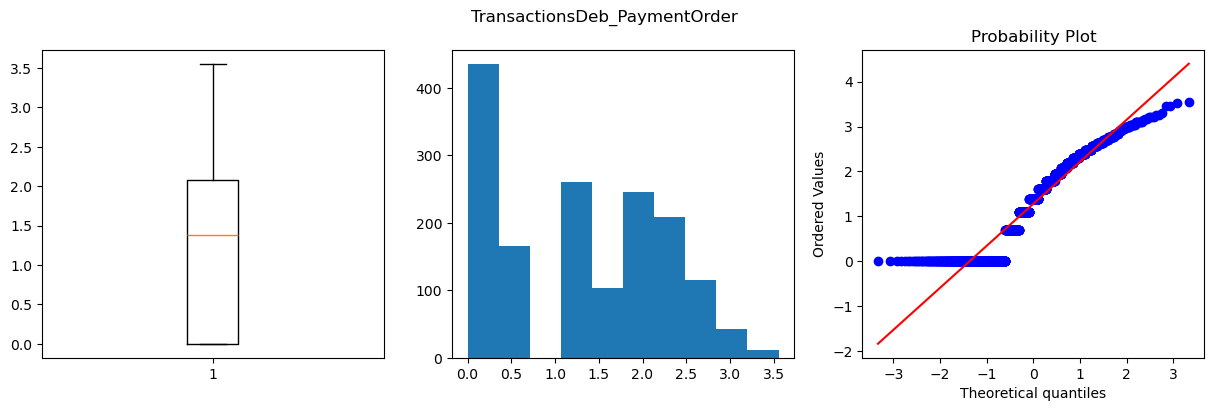

In [14]:
from sklearn.preprocessing import FunctionTransformer

logarithm_transformer = FunctionTransformer(np.log1p, validate=True)

# Apply the transformation to the skewed features
skewed_columns = ['Count_MF',
         'ActBal_CA',
         'ActBal_SA',
         'ActBal_MF',
         'ActBal_OVD',
         'ActBal_CC',
         'ActBal_CL',
         'VolumeCred',
         'VolumeCred_CA',
         'TransactionsCred',
         'TransactionsCred_CA',
         'VolumeDeb',
         'VolumeDeb_CA',
         'VolumeDebCash_Card',
         'VolumeDebCashless_Card',
         'VolumeDeb_PaymentOrder',
         'TransactionsDeb',
         'TransactionsDeb_CA',
         'TransactionsDebCash_Card',
         'TransactionsDebCashless_Card',
         'TransactionsDeb_PaymentOrder']         

df_features_transformed = df_encoded_Soc_Products_Flow.copy()

# Make all the values of 'ActBal_CC' positive
df_features_transformed['ActBal_CC'] = df_features_transformed['ActBal_CC'] - df_features_transformed['ActBal_CC'].min()

arr_transformed = logarithm_transformer.transform(df_features_transformed[skewed_columns].values)

for idx in range(len(skewed_columns)):
    df_features_transformed[skewed_columns[idx]] = arr_transformed[:, idx]

for col in skewed_columns: 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    fig.suptitle(col)
    axes[0].boxplot(df_features_transformed[col])
    axes[1].hist(df_features_transformed[col])
    stats.probplot(df_features_transformed[col], dist='norm', plot=axes[2])
    plt.show()    
  

#### <span style="color:orange">**Comments**</span>

It can be seen that for most of the features, the value distribution gets closer to normal distribution form after applying data transformation. <br/><br/>
For the features 'Count_MF', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', and 'ActBal_CL', the value distribution are still very skewed. Since the value ranges of these features are fairly small, no further data transformation is going to applied to these features. 

In [16]:
# Create the dataset for training
df_modeling = pd.merge(left=df_features_transformed, right=df_Sales_Revenues, left_on='Client', right_on='Client')

# Create the dataset for prediction
df_outer = pd.merge(left=df_features_transformed, right=df_Sales_Revenues, how='outer', left_on='Client', right_on='Client', indicator = True)
df_prediction = df_outer[(df_outer._merge=='left_only')].drop(['_merge', 
                                                               'Sale_MF',
                                                               'Sale_CC',
                                                               'Sale_CL',
                                                               'Revenue_MF',
                                                               'Revenue_CC',
                                                               'Revenue_CL'], axis=1)

## 4. Building Classification Models to Predict Product Purchase Propensity

### Building Baseline Models

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

df_build = df_modeling.drop(['Client'], axis=1).astype('float32')
arr_build = df_build.values

X = arr_build[:, :-6]

y_Sale_MF = arr_build[:, -6]
y_Sale_CC = arr_build[:, -5]
y_Sale_CL = arr_build[:, -4]

In [16]:
target_names = ['Sale_MF', 'Sale_CC', 'Sale_CL']
target_sets = [y_Sale_MF, y_Sale_CC, y_Sale_CL]

# decisionTreeClassifier is used as the baseline model
# The model is trained and evaluated using 10-fold cross-validation
for target_name, target_set in zip(target_names, target_sets):
    
    y = target_set
    
    # 10-fold random stratified cross-validation
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42) 
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
    
    dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced')
    
    print(f"\n****** Baseline Model Metrics for {target_name} ******")
    
    # Accuracy score
    print("\nMean CV Accuracy:", cross_val_score(dtc, X, y, scoring="accuracy", cv=cv, n_jobs=-1).mean())  

    # ROC-AUC
    print("Mean CV ROC-AUC:", cross_val_score(dtc, X, y, scoring="roc_auc", cv=cv, n_jobs=-1).mean()) 





****** Baseline Model Metrics for Sale_MF ******

Mean CV Accuracy: 0.7129605263157895
Mean CV ROC-AUC: 0.5496666666666667

****** Baseline Model Metrics for Sale_CC ******

Mean CV Accuracy: 0.6476644736842105
Mean CV ROC-AUC: 0.5272568381302307

****** Baseline Model Metrics for Sale_CL ******

Mean CV Accuracy: 0.5804166666666667
Mean CV ROC-AUC: 0.5124967693997544


#### <span style="color:orange">**Comments**</span>

The metrics scores show that:
* The baseline models perform well when predicting the Non-Purchase class (Sale_MF==0, Sale_CC==0, Sale_CL==0), but are not able to make accurate predictions for the Purchase class (Sale_MF==1, Sale_CC==1, Sale_CL==1). 
* Both false positive rates and false negative rates are high. 


The problem comes from the imbalance of the classes in the target variables. **Oversampling** techniqhes are going to be used to generate balanced dataset to improve the model quality. 

In [17]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
data_splits = cv.split(X, y_Sale_MF)

In [78]:
for train_indices, test_indices in data_splits:
    X_train = X[train_indices]
    y_train = y_Sale_MF[train_indices]
    
    X_test = X[test_indices]
    y_test = y_Sale_MF[test_indices]
    
    df_train = pd.DataFrame(np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1))
    num_cols = X_train.shape[1]
    df_train.rename(columns={num_cols: "target"}, inplace=True)
    
    print(num_cols)
    print(y_train.shape)
    print(df_train.head())
 
    
    break


29
(856,)
      0      1    2    3         4    5    6    7         8    9  ...  \
0  38.0  165.0  1.0  0.0  0.000000  0.0  0.0  0.0  8.817779  0.0  ...   
1  29.0  106.0  1.0  0.0  0.000000  0.0  0.0  0.0  3.333479  0.0  ...   
2  14.0  187.0  1.0  0.0  0.000000  1.0  0.0  0.0  5.848420  0.0  ...   
3  57.0   50.0  1.0  0.0  0.000000  1.0  1.0  0.0  3.915887  0.0  ...   
4  69.0   55.0  1.0  1.0  2.197225  1.0  0.0  1.0  8.616189  0.0  ...   

        20        21        22        23        24        25        26  \
0  0.00000  0.000000  6.572682  0.693147  0.693147  0.000000  0.000000   
1  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.00000  4.720601  3.009917  1.791759  1.791759  0.000000  1.609438   
3  6.41041  2.936892  6.738449  3.295837  3.178054  1.609438  0.693147   
4  0.00000  5.357445  0.000000  2.079442  1.791759  0.000000  1.386294   

         27   28  target  
0  0.693147  1.0     0.0  
1  0.000000  1.0     0.0  
2  0.693147  1.0     0.0 

### Comparing Different Oversampling Techniques

###### Random Oversampling with Replacement

In [82]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, roc_auc_score

target_names = ['Sale_MF', 'Sale_CC', 'Sale_CL']
target_indeces = [-6, -5, -4]

for target_name, target_index in zip(target_names, target_indeces):
    
    X = arr_build[:, :-6]
    y = arr_build[:, target_index]

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
    cv_splits = cv.split(X, y)
    
    avg_accuracy = 0.0
    avg_roc_auc = 0.0
    for train_indices, test_indices in cv_splits:
        X_train = X[train_indices]
        y_train = y_Sale_MF[train_indices]

        X_test = X[test_indices]
        y_test = y_Sale_MF[test_indices]    
        
        df_train = pd.DataFrame(np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1))
        num_cols = X_train.shape[1]
        df_train.rename(columns={num_cols: 'target'}, inplace=True)

        majority = df_train[df_train['target'] == 0]   # Majority class
        minority = df_train[df_train['target'] == 1]   # Minority class

        # Oversample the minority class by using random selection with replacement
        minority_oversampled = resample(minority, replace=True, n_samples=majority.shape[0], random_state=42) 

        # Generate the balanced dataset 
        df_oversampled = pd.concat([majority, minority_oversampled])
    
        # print(f"****** Target Value Counts for {target_name} ******")
        # print(df_oversampled['target'].value_counts())
        # print("\n")

        arr_train = df_oversampled.values

        X_train = arr_train[:, :-1]
        y_train = arr_train[:, -1]

        # DecisionTreeClassifier is used to build the baseline as no feature scaling is needed.
        dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced')

        # Fitting and making predictions
        dtc.fit(X_train, y_train)
        y_pred_dtc = dtc.predict(X_test)
        y_proba_dtc = dtc.predict_proba(X_test)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred_dtc)
        roc_auc = roc_auc_score(y_test, y_proba_dtc)
        
        avg_accuracy += accuracy
        avg_roc_auc += roc_auc
        
    
    avg_accuracy = avg_accuracy / 10.0
    avg_roc_auc = avg_roc_auc / 10.0   
        
    print(f"\n****** Decision Tree on Random Oversampling Data for {target_name} ******")    

    # Accuracy score
    print("\nMean CV Accuracy:", avg_accuracy)  

    # ROC-AUC
    print("Mean CV ROC-AUC:", avg_roc_auc)    
  
    


****** Decision Tree on Random Oversampling Data for Sale_MF ******

Mean CV Accuracy: 0.6971929824561404
Mean CV ROC-AUC: 0.5377543859649123

****** Decision Tree on Random Oversampling Data for Sale_CC ******

Mean CV Accuracy: 0.6730043859649123
Mean CV ROC-AUC: 0.5374995736114819

****** Decision Tree on Random Oversampling Data for Sale_CL ******

Mean CV Accuracy: 0.6940241228070174
Mean CV ROC-AUC: 0.5319141569950494


######  Synthetic Minority Oversampling Technique (SMOTE)

In [83]:
from imblearn.over_sampling import SMOTE
from collections import Counter


for target_name, target_index in zip(target_names, target_indeces):
    
    X = arr_build[:, :-6]
    y = arr_build[:, target_index]

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
    cv_splits = cv.split(X, y)
    
    avg_accuracy = 0.0
    avg_roc_auc = 0.0
    for train_indices, test_indices in cv_splits:
        X_train = X[train_indices]
        y_train = y_Sale_MF[train_indices]

        X_test = X[test_indices]
        y_test = y_Sale_MF[test_indices]    
        
        oversample = SMOTE()
        X_smote, y_smote = oversample.fit_resample(X_train, y_train)  
    
        # print(f"****** Target Value Counts for {target_name} ******")
        # print(df_oversampled['target'].value_counts())
        # print("\n")

        # DecisionTreeClassifier is used to build the baseline as no feature scaling is needed.
        dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced')

        # Fitting and making predictions
        dtc.fit(X_smote, y_smote)
        y_pred_dtc = dtc.predict(X_test)
        y_proba_dtc = dtc.predict_proba(X_test)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred_dtc)
        roc_auc = roc_auc_score(y_test, y_proba_dtc)
        
        avg_accuracy += accuracy
        avg_roc_auc += roc_auc
        
    
    avg_accuracy = avg_accuracy / 10.0
    avg_roc_auc = avg_roc_auc / 10.0   
        
    print(f"\n****** Decision Tree on Random Oversampling Data for {target_name} ******")    

    # Accuracy score
    print("\nMean CV Accuracy:", avg_accuracy)  

    # ROC-AUC
    print("Mean CV ROC-AUC:", avg_roc_auc)    
  



****** Decision Tree on Random Oversampling Data for Sale_MF ******

Mean CV Accuracy: 0.6687719298245616
Mean CV ROC-AUC: 0.5175438596491228

****** Decision Tree on Random Oversampling Data for Sale_CC ******

Mean CV Accuracy: 0.659375
Mean CV ROC-AUC: 0.5434889127648288

****** Decision Tree on Random Oversampling Data for Sale_CL ******

Mean CV Accuracy: 0.6730153508771929
Mean CV ROC-AUC: 0.5337874411081743


The comparison of the model matrics scores between the oversampling techniqhes and the baseline indicates that:
* Using the oversampling techniqhes has significantly improved the model quality; both false positive rates and false negative rates have been reduced. 
* **Random Oversampling with Replacement** gives the best results for all the 3 classification tasks. Therefore, this oversampling technique will be selected to generate balanced dataset in the following model building prosess. 

### Comparing Different Modeling Methods

In [85]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# A set of ensemble models are defined to accurately fit the data.
models = [RandomForestClassifier(random_state=0), 
          ExtraTreesClassifier(random_state=0), 
          GradientBoostingClassifier(random_state=0), 
          XGBClassifier(random_state=0)]
model_names = ["RandomForest", "ExtraTrees", "GradientBoosting", "XGBoost"]

# Define targets
target_names = ['Sale_MF', 'Sale_CC', 'Sale_CL']
target_indeces = [-6, -5, -4]


def cross_validate_models(df_build: pd.DataFrame, dataset_name: str) -> None:
    

    for target_name, target_index in zip(target_names, target_indeces):
        arr_build = df_build.values
        
        X = arr_build[:, :-6]
        y = arr_build[:, target_index]
       
        # 10-fold random stratified cross-validation
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 

        print(f"****** Model Metrics for {target_name} on {dataset_name} ******")

        # Getting matrics scores for the different models
        for model, model_name in zip(models, model_names):

            print(f"-- {model_name} --")
            # Accuracy score
            print("\nMean CV Accuracy:", cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1).mean())  

            # ROC-AUC
            print("Mean CV ROC-AUC:", cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1).mean())        
            print()     
            
            
cross_validate_models(df_build, "Original Dataset")            

****** Model Metrics for Sale_MF on Original Dataset ******
-- RandomForest --

Mean CV Accuracy: 0.8054714912280702
Mean CV ROC-AUC: 0.5626145198522623

-- ExtraTrees --

Mean CV Accuracy: 0.8012719298245614
Mean CV ROC-AUC: 0.6077976454293629

-- GradientBoosting --

Mean CV Accuracy: 0.8033881578947367
Mean CV ROC-AUC: 0.5670656048014775

-- XGBoost --

Mean CV Accuracy: 0.7854934210526315
Mean CV ROC-AUC: 0.5845443213296398

****** Model Metrics for Sale_CC on Original Dataset ******
-- RandomForest --

Mean CV Accuracy: 0.7823464912280702
Mean CV ROC-AUC: 0.6207784574799845

-- ExtraTrees --

Mean CV Accuracy: 0.7497368421052631
Mean CV ROC-AUC: 0.6132061744460321

-- GradientBoosting --

Mean CV Accuracy: 0.7771052631578947
Mean CV ROC-AUC: 0.5946830135401782

-- XGBoost --

Mean CV Accuracy: 0.7370942982456141
Mean CV ROC-AUC: 0.5786578822775622

****** Model Metrics for Sale_CL on Original Dataset ******
-- RandomForest --

Mean CV Accuracy: 0.7139583333333333
Mean CV ROC-AUC: 

In [30]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42) 
train = cv.split(df_build)

In [34]:
type(train)


generator

### Investigating Usefulness of the Created Features

In [ ]:
df_build_enriched = df_modeling_enriched.drop(['Client'], axis=1).astype('float32')

cross_validate_models(df_build_enriched, "Enriched Dataset")   


By comparing the metrics scores for different ensemble modeling methods on the original and enriched datasets, it can be concluded that:
* All these ensemble learning methods can significantly improve the model quality.
* For all the 3 classification tasks, the ExtraTrees models give the best mean Accuracy and mean ROC-AUC in cross-validation. So, in **ExtraTrees** is choosed to build the classification models.  
* No significant medel quality improvement has been introduced by using the created features. So, the created features will not be used in building the classification models.

### Optimizing Model Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

def gridSearch_pipeline(X_train, y_train,
                       model, param_grid, cv=10, scoring_fit='r2'):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train, y_train)
    
    return fitted_model


for target_name, target_index in zip(target_names, target_indeces):

    majority = df_build[df_build[target_name] == 0]   # Majority class
    minority = df_build[df_build[target_name] == 1]   # Minority class

    # Oversample the minority class by using random selection with replacement
    minority_oversampled = resample(minority, replace=True, n_samples=majority.shape[0], random_state=42) 

    # Generate the balanced dataset 
    df_oversampled = pd.concat([majority, minority_oversampled])

    arr_build = df_oversampled.values

    X = arr_build[:, :-6]
    y = arr_build[:, target_index]

    model = ExtraTreesClassifier(random_state=0)
    param_grid = {
                    'n_estimators': [40, 60, 80, 100, 120, 140, 160, 200, 220, 240, 260, 280, 300],
                    'max_depth': [28, 30, 32, 34, 36],
                    'criterion': ['gini', 'entropy', 'log_loss'],
                    'ccp_alpha': [0.001, 0.002, 0.004]
                }   
    
    model = gridSearch_pipeline(X, y, model, param_grid, cv=10, scoring_fit='roc_auc')  
    
    print(f"****** Best Scores/Hyperparameters for {target_name} ******")
    print(model.best_score_)
    print(model.best_params_) 

### Building Final Classification Models

In [ ]:
from sklearn.metrics import roc_curve

target_hyperparas = [
                        {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 36, 'n_estimators': 80},
                        {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 36, 'n_estimators': 280},
                        {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 28, 'n_estimators': 260}
                    ]

# Plot ROC curves to describe the model quality

for target_name, target_index, hyperparas in zip(target_names, target_indeces, target_hyperparas):
    majority = df_build[df_build[target_name] == 0]   # Majority class
    minority = df_build[df_build[target_name] == 1]   # Minority class

    # Oversample the minority class by using random selection with replacement
    minority_oversampled = resample(minority, replace=True, n_samples=majority.shape[0], random_state=42) 

    # Generate the balanced dataset 
    df_oversampled = pd.concat([majority, minority_oversampled])

    arr_build = df_oversampled.values

    X = arr_build[:, :-6]
    y = arr_build[:, target_index]    

    # Split the dataset into train and test datasets

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build ExtraTreesClassifier model with the best hyperparameters
    model = ExtraTreesClassifier(
                                    n_estimators=hyperparas['n_estimators'],
                                    max_depth=hyperparas['max_depth'],
                                    criterion=hyperparas['criterion'],
                                    ccp_alpha=hyperparas['ccp_alpha'],       
                                    random_state=0
                                )

    # Fitting and making predictions
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

    plt.figure(figsize=(6, 4))
    plt.plot([0, 1], [0, 1], 'k--')

    # Plot tpr against fpr
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {target_name} Prediction', fontdict={'fontsize': 10})
    plt.show()    


In [ ]:
# Build final classification models

def train_classifier(df_build: pd.DataFrame, target_name: str, target_index: int, hyperparas: dict) -> ExtraTreesClassifier:
    
    majority = df_build[df_build[target_name] == 0]   # Majority class
    minority = df_build[df_build[target_name] == 1]   # Minority class
    
    # Oversample the minority class by using random selection with replacement
    minority_oversampled = resample(minority, replace=True, n_samples=majority.shape[0], random_state=42) 

    # Generate the balanced dataset 
    df_oversampled = pd.concat([majority, minority_oversampled])

    arr_build = df_oversampled.values   
    
    X = arr_build[:, :-6]
    y = arr_build[:, target_index]    

    model = ExtraTreesClassifier(
                                    n_estimators=hyperparas['n_estimators'],
                                    max_depth=hyperparas['max_depth'],
                                    criterion=hyperparas['criterion'],
                                    ccp_alpha=hyperparas['ccp_alpha'],       
                                    random_state=0
                                )
    
    model.fit(X, y)
    
    return model
    

classifier_Sale_MF = train_classifier(df_build, target_names[0], target_indeces[0], target_hyperparas[0])

classifier_Sale_CC = train_classifier(df_build, target_names[1], target_indeces[1], target_hyperparas[1])

classifier_Sale_CL  = train_classifier(df_build, target_names[2], target_indeces[2], target_hyperparas[2])


## Building Regression Models to Predict Product Purchase Revenue

### Exploring Modeling Methods and Regression Errors 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

models = [RandomForestRegressor(random_state=0), 
          GradientBoostingRegressor(random_state=0), 
          XGBRegressor(booster='gblinear', random_state=0)]
model_names = ["RandomForest", "GradientBoosting", "XGBoost"]

target_names = ['Revenue_MF', 'Revenue_CC', 'Revenue_CL']
target_indeces = [-3, -2, -1]


for target_name, target_index in zip(target_names, target_indeces):

    df_Rev_build = df_modeling[df_modeling[target_name]!=0].drop(['Client'], axis=1).astype('float32')

    arr_build = df_Rev_build.values
    
    # Scale the data using StandardScaler, as the ensemble regression models are sensetive to scaling 
    scaler = StandardScaler()
    
    arr_scaled = scaler.fit_transform(arr_build)

    X = arr_scaled[:, :-6]
    y = arr_scaled[:, target_index]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"****** Cross-Validation Scores for {target_name} ******")
  
    for model, model_name in zip(models, model_names):
        
        model = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        print(f"-- {model_name} --")
        # R^2 score
        print("\tMean negtive MAPE:", cross_val_score(model, X, y, scoring="neg_mean_absolute_percentage_error", cv=10, n_jobs=-1).mean()) 
        
        # MAPE on the test set
        print("\tMAPE on test set:", mean_absolute_percentage_error(y_test, y_pred), "\n") 


Cross-validation results show that the MAPE scroes for different modeling algorithms are quite high. **GradientBoostingRegressor** is selected to build the final regression models, as it can be used to generate prediction intervals to give a reasonable range of estimation. 

In [ ]:
# Set lower and upper quantile to produce a 90% confidence interval
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

# Investigate the prediction interval by using GradientBoostingRegressor 
for target_name, target_index in zip(target_names, target_indeces):
    
    df_Rev_build = df_modeling[df_modeling[target_name]!=0].drop(['Client'], axis=1).astype('float32')

    arr_build = df_Rev_build.values
    
    # Scale the data using StandardScaler, as the ensemble regression models are sensetive to scaling 
    scaler = StandardScaler()
    
    arr_scaled = scaler.fit_transform(arr_build)

    X = arr_scaled[:, :-6]
    y = arr_scaled[:, target_index]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"****** Modeling Results for {target_name} ******")    
    
    # Each model has to be separate
    lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA)

    # The mid model will use the default loss
    mid_model = GradientBoostingRegressor(loss="quantile", alpha=0.5)

    upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA)


    # Fit models
    lower_model.fit(X_train, y_train)
    mid_model.fit(X_train, y_train)
    upper_model.fit(X_train, y_train)
    
    # Get actual values
    predictions = pd.DataFrame(y_test, columns=['actual'])
    
    # Predict
    predictions['lower'] = lower_model.predict(X_test)
    predictions['mid'] = mid_model.predict(X_test)
    predictions['upper'] = upper_model.predict(X_test)
    
    predictions.plot(kind='line',figsize=(6, 4))
    plt.show()


The plots of prediction intervals indicate that the models trained with the quantile loss and different alpha values can generate the good prediction intervals:
* The actual values are usually within the interval derived by the "lower" and "upper" models.
* The "mid" models can be used to generate reasonable estimates of the actual target values. 
<br/><br/>

Therefore, in the marketing optimization, we are going to use the "mid" models to estimate the revenues, while the "lower" and "upper" models will be used to give the 90% confidence interval of the estimation.   

### Building Final Regression Models

In [ ]:
# Build final classification models
def train_regressors(df_modeling: pd.DataFrame, target_name, target_index: int) -> (GradientBoostingRegressor,
                                                                                    GradientBoostingRegressor,
                                                                                    GradientBoostingRegressor,
                                                                                    StandardScaler):
    
    df_Rev_build = df_modeling[df_modeling[target_name]!=0].drop(['Client'], axis=1).astype('float32')

    arr_build = df_Rev_build.values
    
    X = arr_build[:, :-6]
    y = arr_build[:, target_index].reshape(-1, 1)    
    
    arr_filtered = np.concatenate((X, y), axis=1)
    
    # Scale the data using StandardScaler 
    scaler = StandardScaler()
    
    arr_scaled = scaler.fit_transform(arr_filtered)
    
    X_scaled = arr_scaled[:, :-1]
    y_scaled = arr_scaled[:, -1]    
    
    # Define models
    lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA)
    mid_model = GradientBoostingRegressor(loss="quantile", alpha=0.5)
    upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA)
    
    # Fit models
    lower_model.fit(X_scaled, y_scaled)
    mid_model.fit(X_scaled, y_scaled)
    upper_model.fit(X_scaled, y_scaled)
    
    return lower_model, mid_model, upper_model, scaler


reg_rev_MF_lower, reg_rev_MF_mid, reg_rev_MF_upper, scaler_rev_MF = train_regressors(df_modeling, 
                                                                                     target_names[0], 
                                                                                     target_indeces[0])

reg_rev_CC_lower, reg_rev_CC_mid, reg_rev_CC_upper, scaler_rev_CC = train_regressors(df_modeling, 
                                                                                     target_names[1], 
                                                                                     target_indeces[1])

reg_rev_CL_lower, reg_rev_CL_mid, reg_rev_CL_upper, scaler_rev_CL = train_regressors(df_modeling, 
                                                                                     target_names[2], 
                                                                                     target_indeces[2])


## Generate Optimazation Results to Maximize Revenue

### Estimating Buying Propensity Using the Classification Models

In [ ]:
df_propensity = pd.DataFrame().assign(Client=df_prediction['Client'])
array_prediction = df_prediction.drop(['Client'], axis=1).astype('float32').values
total_num_clients = array_prediction.shape[0]

prob_names = ['prob_MF', 'prob_CC', 'prob_CL']
classifiers = [classifier_Sale_MF, classifier_Sale_CC, classifier_Sale_CL]
target_rates = [target_rate_Sale_MF, target_rate_Sale_CC, target_rate_Sale_CL]

for prob_name, classifier, target_rate in zip(prob_names, classifiers, target_rates):

    # Estimate the probability for a specific product
    probs = classifier.predict_proba(array_prediction)[:, 1]

    # Normalize the probability to make the target rate consistent with that in the training set  
    propensity = probs * (target_rate * total_num_clients) / probs.sum() 

    df_propensity[prob_name] = propensity


### Estimating Revenue and Confidence Intervals Using the Regression Models

In [ ]:
rev_names = [{'mid': 'rev_MF', 'lower': 'rev_MF_lower', 'upper': 'rev_MF_upper'},
             {'mid': 'rev_CC', 'lower': 'rev_CC_lower', 'upper': 'rev_CC_upper'},
             {'mid': 'rev_CL', 'lower': 'rev_CL_lower', 'upper': 'rev_CL_upper'}]

regressors  = [{'mid': reg_rev_MF_mid, 'lower': reg_rev_MF_lower, 'upper': reg_rev_MF_upper},
               {'mid': reg_rev_CC_mid, 'lower': reg_rev_CC_lower, 'upper': reg_rev_CC_upper},
               {'mid': reg_rev_CL_mid, 'lower': reg_rev_CL_lower, 'upper': reg_rev_CL_upper}]

scalers = [scaler_rev_MF, scaler_rev_CC, scaler_rev_CL]


for rev_name, regressor, scaler in zip(rev_names, regressors, scalers):

    # Scale the features
    array_scaled = scaler.transform(np.hstack((array_prediction, np.zeros((array_prediction.shape[0], 1)))))

    # Estimate the revenue for a specific product
    rev = regressor['mid'].predict(array_scaled[:, :-1])
    rev_lower = regressor['lower'].predict(array_scaled[:, :-1])
    rev_upper = regressor['upper'].predict(array_scaled[:, :-1])

    # Invert scaling for prediction
    inv_rev = np.concatenate((array_scaled[:, :-1], rev.reshape(-1, 1)), axis=1)
    inv_rev = scaler.inverse_transform(inv_rev)
    inv_rev = inv_rev[:, -1]

    inv_rev_lower = np.concatenate((array_scaled[:, :-1], rev_lower.reshape(-1, 1)), axis=1)
    inv_rev_lower = scaler.inverse_transform(inv_rev_lower)
    inv_rev_lower = inv_rev_lower[:,-1]

    inv_rev_upper = np.concatenate((array_scaled[:, :-1], rev_upper.reshape(-1, 1)), axis=1)
    inv_rev_upper = scaler.inverse_transform(inv_rev_upper)
    inv_rev_upper = inv_rev_upper[:, -1]


    df_propensity[rev_name['mid']] = inv_rev
    df_propensity[rev_name['lower']] = inv_rev_lower
    df_propensity[rev_name['upper']] = inv_rev_upper


### Generating Optimization Results for Direct Marketing Campaign

In [ ]:
df_predicted = df_propensity.copy()

for product_name in ['MF', 'CC', 'CL']:
    # Calculate the expected revenue for each product
    df_predicted[f'rev_{product_name}_exp'] = df_predicted[f'prob_{product_name}'] * df_predicted[f'rev_{product_name}']
    df_predicted[f'rev_{product_name}_lower_exp'] = df_predicted[f'prob_{product_name}'] * df_predicted[f'rev_{product_name}_lower']
    df_predicted[f'rev_{product_name}_upper_exp'] = df_predicted[f'prob_{product_name}'] * df_predicted[f'rev_{product_name}_upper']
    
# Calculate the expected total revenue    
df_predicted['rev_total_exp'] = df_predicted['rev_MF_exp'] + df_predicted['rev_CC_exp'] + df_predicted['rev_CL_exp']
df_predicted['rev_total_lower_exp'] = df_predicted['rev_MF_lower_exp'] + df_predicted['rev_CC_lower_exp'] + df_predicted['rev_CL_lower_exp']
df_predicted['rev_total_upper_exp'] = df_predicted['rev_MF_upper_exp'] + df_predicted['rev_CC_upper_exp'] + df_predicted['rev_CL_upper_exp']

# Get the top 100 clients to maximize the expected total revenue  
df_predicted = df_predicted.sort_values(by='rev_total_exp', axis=0, ascending=False)
df_optimized = df_predicted.iloc[0:100]

df_optimized = df_optimized[['Client', 'prob_MF', 'prob_CC', 'prob_CL', 'rev_total_exp', 'rev_total_lower_exp', 'rev_total_upper_exp'] ]

print(f"Expected Number of Clients to Buy MF: {df_optimized['prob_MF'].values.sum()}")
print(f"Expected Number of Clients to Buy CC: {df_optimized['prob_CC'].values.sum()}")
print(f"Expected Number of Clients to Buy CL: {df_optimized['prob_CL'].values.sum()}")

print(f"Expected Total Revenue: {df_optimized['rev_total_exp'].values.sum()}")
print(f"90% Confidence Interval of Expected Total Revenue: [{df_optimized['rev_total_lower_exp'].values.sum()}, {df_optimized['rev_total_upper_exp'].values.sum()}]")


In [ ]:
df_optimized.to_csv("Campaign_Targets.csv", index=False)

In [ ]:
df_propensity['prob_MF'].values